# Import Libraries

In [127]:
%matplotlib inline

import pandas as pd
import numpy as np

import datetime 
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.backends.backend_pdf import PdfPages
import glob
import os

import sys
import itertools
from matplotlib import rcParams

import io
import requests

import fbprophet
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

import statsmodels.api as sm

from sklearn.metrics import mean_absolute_error as MAE
from scipy.stats import skew

import folium
from folium.plugins import MarkerCluster


import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )

import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import wellapplication as wa

rcParams['figure.figsize'] = 15, 10
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 14

https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#additional-regressors

https://nbviewer.jupyter.org/github/nicolasfauchereau/Auckland_Cycling/blob/master/notebooks/Auckland_cycling_and_weather.ipynb

In [2]:
fbprophet.__version__

'0.5'

In [3]:
codepath = "G:/My Drive/Python/GitHub/Leland Harris Analysis/"
sys.path.append(codepath)
import utils

In [4]:
#llpath = "E:/My Drive/Python/Pycharm/loggerloader/"
llpath = "G:/My Drive/Python/Pycharm/loggerloader/"
sys.path.append(llpath)
import loggerloader as ll

In [5]:
import importlib.util
spec = importlib.util.spec_from_file_location("dbconnect", "G:/My Drive/Python/dbconnect.py")
dbconnect = importlib.util.module_from_spec(spec)
spec.loader.exec_module(dbconnect)
engine = dbconnect.postconn_ugs()

In [6]:
#file_place = "G:/My Drive/WORK/Leland_Harris/intermediate_data/"
file_place = "G:/My Drive/WORK/Leland_Harris/intermediate_data/"
figure_place = file_place + "prophet/"

# Define Functions

In [156]:
def proph_run(comb_data_day, regvar=None, samprate='1D', splityr=2017, 
              file_place="G:/My Drive/WORK/Leland_Harris/prophet_out/"):

    model = {}
    forecast = {}
    verif = {}
    modresults = []

    comb_data_day = comb_data_day['2010-10-01':'2019-09-01']
    for col in comb_data_day:
        if 'wle' in col and col not in ('1066_wle','1061_wle'):
            df = comb_data_day.rename(columns={col:'y'}).resample(samprate).mean()
            df.index.name = 'datetime'
            
            if regvar and regvar is not 'noreg':
                df[regvar] = df[regvar].interpolate(method='time').replace(np.nan,0)
            data_train, data_test = utils.prepare_data(df, splityr)
            m = Prophet(seasonality_mode='additive', 
                        weekly_seasonality=False)
            if regvar and regvar is not 'noreg':
                m.add_regressor(regvar, mode='additive')
            else:    
                regvar = 'noreg'
            m.fit(data_train)
            future = m.make_future_dataframe(periods=len(data_test), freq=samprate)
            futures = future.copy() 
            futures.index = pd.to_datetime(futures.ds)
            futures = futures.merge(df, left_index=True, right_index=True)
            futures = futures.reset_index(drop = True)

            forecast[col] = m.predict(futures)
            model[col] = m
            verif[col] = utils.make_verif(forecast[col], data_train, data_test)

            fig1 = plot_verif(verif[col],freq=samprate)
            a = add_changepoints_to_plot(fig1.gca(), m, forecast[col])
            plt.ylabel('Water Elevation (ft)')
            fig1.savefig(file_place+f"prophet_{col}_{samprate}_{regvar}_v{vers}.pdf")
            plt.close()

            fig2 = m.plot_components(forecast[col])
            fig2.savefig(file_place+f"prophet_{col}_comp_{samprate}_{regvar}_v{vers}.pdf")
            plt.close()

            try:
                fig3 = plot_joint_plot(verif[col].loc[f'{splityr}':,['yhat','y']].dropna(), title=f'Test {col}')
                fig3.savefig(file_place+f"prophet_{col}_joint_{samprate}_{regvar}_v{vers}.pdf")
                plt.close()
            except:
                pass
            verif[col].to_pickle(file_place+f'prophet_{col}_verify_{samprate}_{regvar}_v{vers}.pickle')
            forecast[col].to_pickle(file_place+f'prophet_{col}_forecast_{samprate}_{regvar}_v{vers}.pickle')
            print(col)
            
            ver = verif[col].dropna(subset=['y','yhat'])
            if len(ver.loc[f'{splityr}':,['y','yhat']]) > 0:
                rval = ver.loc[f'{splityr}':,['y','yhat']].corr().iloc[0,1]
                maeval = MAE(ver.loc[f'{splityr}':,'y'].values, ver.loc[f'{splityr}':,'yhat'].values)
                modresults.append([col,rval,maeval]) 


    results = pd.DataFrame(modresults, columns=['well','R','MAE']).round(2)
    results.to_csv(file_place+f"prophet_fit_table_forecast_{samprate}_{regvar}_v{vers}.csv")
    return results

In [7]:
def calc_wat_year(df):
  df.loc[:,'month'] = df.index.month
  df.loc[:,'year'] = df.index.year
  df.loc[:,'doy'] = df.index.dayofyear
  
  df['water year'] = df.index.shift(-9,freq='M').year+1
  df['ones'] = 1
  df['water year doy'] = df['ones'].groupby(df['water year']).cumsum()
  df['doylen'] = df['ones'].groupby(df['water year']).count()
  df['water year doy1'] = df.apply(lambda df: df['doy']-273 if df['water year'] > df['year'] else df['doy']+92,1)
  return df


In [8]:
def crosscorr(datax, datay, lag=0):
    ''' 
    http://stackoverflow.com/questions/33171413/cross-correlation-time-lag-correlation-with-pandas
    Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    '''
    return datax.corr(datay.shift(lag))

def scatterColor(x0,y,w):
    """Creates scatter plot with points colored by variable.
    All input arrays must have matching lengths

    Arg:
        x0 (array): 
            array of x values
        y (array): 
            array of y values
        w (array): 
            array of scalar values

    Returns:
        slope and intercept of best fit line
    
    """
    import matplotlib as mpl
    import matplotlib.cm as cm
    cmap = plt.cm.get_cmap('RdYlBu')
    norm = mpl.colors.Normalize(vmin=w.min(), vmax=w.max())
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    m.set_array(w)
    sc = plt.scatter(x0, y, label='', color = m.to_rgba(w))

    xa = sm.add_constant(x0)

    est = sm.RLM(y, xa).fit()
    r2 = sm.WLS(y, xa, weights=est.weights).fit().rsquared
    slope = est.params[1]

    x_prime = np.linspace(np.min(x0),np.max(x0),100)[:, np.newaxis]
    x_prime = sm.add_constant(x_prime)
    y_hat = est.predict(x_prime)

    const = est.params[0]
    y2 = [i*slope + const for i in x0]

    plt.xlabel('Barometric Pressure (ft water)')
    plt.ylabel('Transducer Pressure (ft water)')
    lin = linregress(x0,y)
    x1 = np.arange(np.min(x0), np.max(x0),0.1)
    y1 = [i*lin[0]+lin[1] for i in x1]
    y2 = [i*slope+const for i in x1]
    plt.plot(x1,y1,c='g',label='simple linear regression m = {:.2f} b = {:.0f}, r^2 = {:.2f}'.format(lin[0],lin[1],lin[2]**2))
    plt.plot(x1,y2,c='r',label='rlm regression m = {:.2f} b = {:.0f}, r2 = {:.2f}'.format(slope,const,r2))
    plt.legend()
    cbar = plt.colorbar(m)

    cbar.set_label('Julian Date')

    return slope,const

In [9]:
def plotlystuff(datasets, colnames, chrttypes=None, datatitles=None, chrttitle = 'well', colors=None,
                two_yaxes = False, axisdesig= None, axislabels=['Levels','Barometric Pressure']):
    
    if chrttypes is None:
        chrttypes = ['lines']*len(datasets)
    
    if datatitles is None:
        datatitles = colnames
    
    if axisdesig is None:
        axisdesig = ['y1']*len(datasets)
        
    if colors is None:
        if len(datasets) <= 5: 
            colors = ['#228B22','#F7DC6F','#FF1493','#663399','#FF0000']
        else:
            colors = []
            for i in range(len(datasets)):
                colors[i] = '#{:02x}{:02x}{:02x}'.format(r(), r(), r())
        
    r = lambda: random.randint(0,255)
    
    modetypes = ['markers','lines+markers','lines']
    datum = {}
    
    for i in range(len(datasets)):
        datum['d' + str(i)] = go.Scatter(
            x=datasets[i].index,
            y=datasets[i][colnames[i]],
            name = datatitles[i],
            line = dict(color = colors[i]),
            mode = chrttypes[i],
            opacity = 0.8,
            yaxis = axisdesig[i])
        
    data = list(datum.values())

    layout = dict(
        title=chrttitle,
        xaxis=dict(
            rangeslider=dict(
                visible = True
            ),
            type='date',
            tickformat='%Y-%m-%d %H:%M'
        ),
        yaxis=dict(title=axislabels[0],
                   titlefont=dict(color='#1f77b4'),
                   tickfont=dict(color='#1f77b4')),
    )
    
    
    if two_yaxes:
        layout['yaxis2'] = dict(title=axislabels[1], titlefont=dict(color='#ff7f0e'),
                    tickfont=dict(color='#ff7f0e'),
                    anchor='x',
                    overlaying='y',
                    side='right',
                    position=0.15)

    fig = dict(data=data, layout=layout)
    iplot(fig, filename = 'well')
    return 

In [147]:
def plot_joint_plot(verif, x='yhat', y='y', title=None, fpath = '../figures/paper', fname = None): 
    """
    
    Parameters
    ---------- 
    verif : pandas.DataFrame 
    x : string 
        The variable on the x-axis
        Defaults to `yhat`, i.e. the forecast or estimated values.
    y : string 
        The variable on the y-axis
        Defaults to `y`, i.e. the observed values
    title : string 
        The title of the figure, default `None`. 
    
    fpath : string 
        The path to save the figures, default to `../figures/paper`
    fname : string
        The filename for the figure to be saved
        ommits the extension, the figure is saved in png, jpeg and pdf
 
    Returns
    -------
    f : matplotlib Figure object
    """

    g = sns.jointplot(x='yhat', y='y', data = verif, kind="reg", color="0.4")
    
    g.fig.set_figwidth(8)
    g.fig.set_figheight(8)

    ax = g.fig.axes[1]
    
    if title is not None: 
        ax.set_title(title, fontsize=16)

    ax = g.fig.axes[0]
    fudge = verif.yhat.std()/2
    ax.set_xlim([verif.yhat.min()-fudge, verif.yhat.max()+fudge])
    ax.set_ylim([verif.y.min()-fudge, verif.y.max()+fudge])

    ax.text(verif.yhat.min(), verif.y.max()-fudge, "R = {:+4.2f}\nMAE = {:4.2f}".format(verif.loc[:,['y','yhat']].corr().iloc[0,1], MAE(verif.loc[:,'y'].values, verif.loc[:,'yhat'].values)), fontsize=16)

    ax.set_xlabel("model's estimates", fontsize=15)
    
    ax.set_ylabel("observations", fontsize=15)
    
    ax.grid(ls=':')

    [l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
    [l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];

    ax.grid(ls=':')
    return g

In [85]:
def plot_verif(verif, year=2017, freq = '1H'):
    
    verif.index = pd.to_datetime(verif.index)
    f, ax = plt.subplots(figsize=(14, 8))

    train = verif.loc[:str(year - 1),:]

    ax.plot(train.resample(freq).mean().index, train.resample(freq).mean().y, 'ko', markersize=3)

    ax.plot(train.index, train.yhat, color='steelblue', lw=0.5)

    ax.fill_between(train.index, train.yhat_lower, train.yhat_upper, color='steelblue', alpha=0.3)

    test = verif.loc[str(year):,:]

    ax.plot(test.resample(freq).mean().index, test.resample(freq).mean().y, 'ro', markersize=3)

    ax.plot(test.index, test.yhat, color='coral', lw=0.5)

    ax.fill_between(test.index, test.yhat_lower, test.yhat_upper, color='coral', alpha=0.3)

    ax.axvline(pd.to_datetime(str(year),format='%Y'), color='0.8', alpha=0.7)

    ax.grid(ls=':', lw=0.5)

    return f

def plot_verif_component(verif, component='rain', year=2017): 
    """
    plots a specific component of the `verif` DataFrame
   Parameters
    ----------
    verif : pandas.DataFrame
        The `verif` DataFrame coming from the `make_verif` function in this package. 
    component : string 
        The name of the component (i.e. column name) to plot in the `verif` DataFrame. 
    year : integer
        The year used to separate the training and test set. Default 2017
    Returns
    -------
    f : matplotlib Figure object
    """
    verif.index = pd.to_datetime(verif.index)
    f, ax = plt.subplots(figsize=(14, 7))
    
    train = verif.loc[:str(year - 1),:]
        
    ax.plot(train.index, train.loc[:,component] * 100, color='0.8', lw=1, ls='-')
    
    ax.fill_between(train.index, train.loc[:, component+'_lower'] * 100, train.loc[:, component+'_upper'] * 100, color='0.8', alpha=0.3)
    
    test = verif.loc[str(year):,:]
        
    ax.plot(test.index, test.loc[:,component] * 100, color='k', lw=1, ls='-')
    
    ax.fill_between(test.index, test.loc[:, component+'_lower'] * 100, test.loc[:, component+'_upper'] * 100, color='0.8', alpha=0.3)
    
    ax.axvline(pd.to_datetime(str(year),format='%Y'), color='k', alpha=0.7)
    
    ax.grid(ls=':', lw=0.5)
    
    return f

In [12]:
def prepare_data(data, year=2017): 
    """
    prepare the data for ingestion by fbprophet: 
    see: https://facebook.github.io/prophet/docs/quick_start.html
    
    1) divide in training and test set, using the `year` parameter (int)
    
    2) reset the index and rename the `datetime` column to `ds`
    
    returns the training and test dataframes
    Parameters
    ----------
    data : pandas.DataFrame 
        The dataframe to prepare, needs to have a datetime index
    year: integer 
        The year separating the training set and the test set (includes the year)
    Returns
    -------
    data_train : pandas.DataFrame
        The training set, formatted for fbprophet.
    data_test :  pandas.Dataframe
        The test set, formatted for fbprophet.
    """
    
    
    data_train = data.loc[:str(year - 1),:]
    
    data_test = data.loc[str(year):,:]
    
    data_train.reset_index(inplace=True)
    
    data_test.reset_index(inplace=True)
    
    data_train = data_train.rename({'datetime':'ds'}, axis=1)
    
    data_test = data_test.rename({'datetime':'ds'}, axis=1)
    
    return data_train, data_test

# Import and Merge Data

In [25]:
ugs_clim_raw_dly = pd.read_pickle(file_place + "ugs_clim_dly.pickle")
climate_data = pd.read_pickle(file_place+'climate_data.pickle')
wls = pd.read_pickle(file_place+"raw_hydrograph_data.pickle")
st_mt_df = pd.read_pickle(file_place+'climate_station_metadata1.pickle')
wls_piv = pd.read_pickle(file_place+"pivotedwells.pickle")
prismloc = pd.read_pickle(file_place+'prism_local_SG25.pickle')
sntlhrly = pd.read_pickle(file_place+"wheeler_snotel.pickle")

![Changepoint](https://miro.medium.com/max/507/1*jEFOLncknBJ8cPQSBQDktA.png)

In [26]:
prismloc.index = pd.to_datetime(prismloc.index)

In [27]:
prismloc['cdm_ppt'] = prismloc['PRISM_ppt _mm'].apply(lambda x: x- prismloc['PRISM_ppt _mm'].mean(),1).cumsum()
climate_data['cdm_ppt'] = climate_data['PRISM_ppt _mm'].apply(lambda x: x- climate_data['PRISM_ppt _mm'].mean(),1).cumsum()

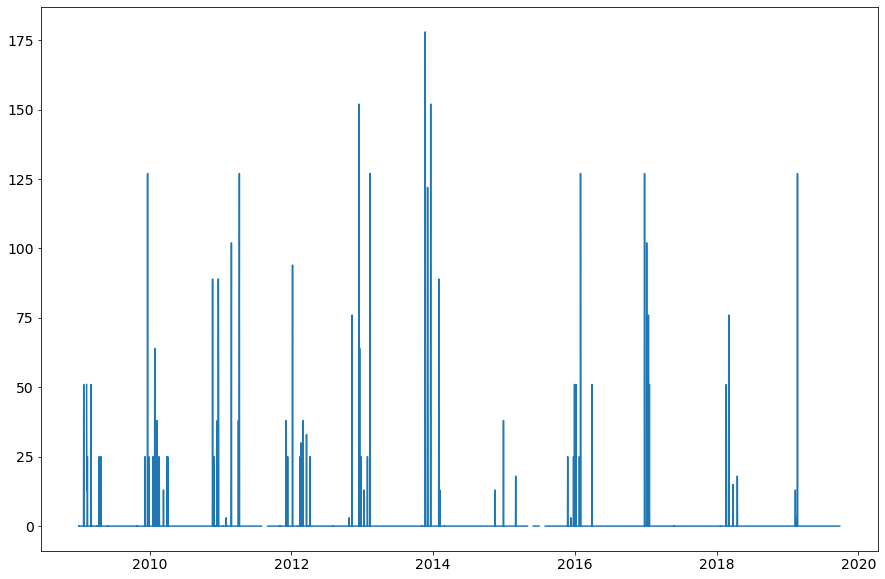

In [28]:
y = climate_data.loc['2009':,'partoun_snowfall']
x = climate_data.loc['2009':,'partoun_snowfall'].index
plt.plot(x,y)

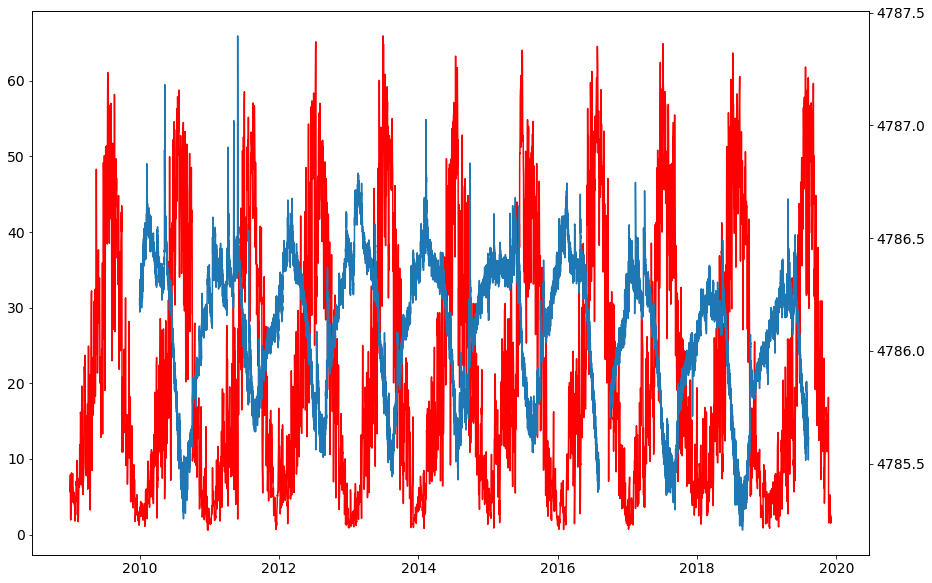

In [29]:
#x = prismloc.index
#y = prismloc['cdm_ppt']
y3 = prismloc.loc['2009':,'PRISM_vpdmax _hpa']
x3 = prismloc.loc['2009':,'PRISM_vpdmax _hpa'].index

plt.plot(x3,y3,color='red')
#plt.plot(x,y,color='red',zorder=0)
x1 = wls_piv.index
y1 = wls_piv['SG25A_wle']
plt.twinx()
plt.plot(x1,y1)

In [30]:
wls_daily = wls_piv.resample('1D').mean()
#wls_daily = wls_daily['2010-11-01':'2019-09-24']
#prismloc = pd.read_pickle(file_place+'prism_local_SG25.pickle')
prismsub=prismloc[['PRISM_vpdmax _hpa','cdm_ppt']].resample('1D').mean().interpolate(method='time')
#climsamp = climate_data.loc['2010-11-01':'2019-09-24',['callao_ppt','callao_maxtemp','callao_et','Wheeler_swe_mm']].resample('1D').mean().interpolate(method='time').dropna()
#climsamp = climate_data.loc['2010-11-01':'2019-09-24',['eskdale_ppt','eskdale_maxtemp','eskdale_et','Wheeler_swe_mm']].resample('1D').mean().interpolate(method='time').dropna()

In [31]:
trout_creek = "https://waterdata.usgs.gov/nwis/inventory?agency_code=USGS&site_no=10172870"
flow_data = wa.nwis('dv',[10172870],'sites')
trout = flow_data.data
trt = trout.rename(columns={'value':'trout'})['trout'].to_frame().resample('1D').mean().interpolate(method='time')


connection successful


In [34]:
trout15url = "https://nwis.waterdata.usgs.gov/usa/nwis/uv/?cb_00060=on&cb_00065=on&format=rdb&site_no=10172870&period=&begin_date=2009-01-01&end_date=2019-12-18"
skipper = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,31]
trout15 = pd.read_csv(io.StringIO(requests.get(trout15url).text),index_col='datetime', 
                      parse_dates=['datetime'], skiprows=skipper,sep='\t')

trout15 = trout15.rename(columns={'144419_00060':'Q_cfs',
                        '144419_00060_cd':'Q_qual',
                        '144420_00065':'Gage_ft','144420_00065_cd':'Gage_qual'})
trout_hr = trout15.groupby(pd.Grouper(freq='1H')).mean().interpolate(method='time')
trout_hr.to_pickle(file_place + "trout_hrly.pickle")

In [35]:
comb_data = pd.concat([wls_daily,prismsub,trt],axis=1)

C:\Users\paulinkenbrandt\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



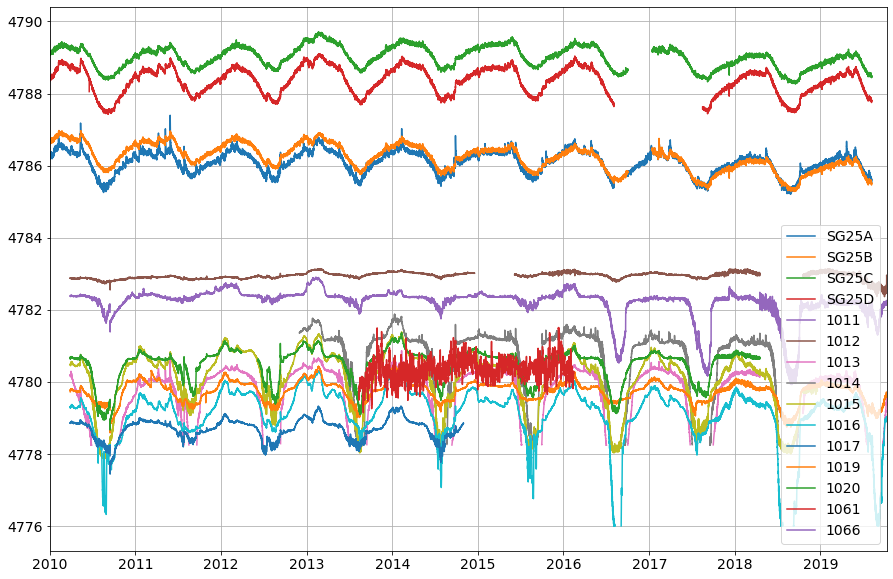

In [36]:

for col in wls_piv:
    if 'wle' in col:
        plt.plot(wls_piv.index,wls_piv[col],label=col.split('_')[0])
plt.legend()
tickdates = pd.date_range(wls_piv.first_valid_index(),wls_piv.last_valid_index(),freq='1YS')
plt.xlim(wls_piv.first_valid_index(),wls_piv.last_valid_index())
plt.xticks(tickdates,[datetime.datetime.strftime(i,'%Y') for i in tickdates])
plt.grid()

# Run Model

## Hourly

In [ ]:
model = {}
forecast = {}

version = 17
file_place = "G:/My Drive/WORK/Leland_Harris/prophet_out/"
wls = pd.read_pickle(file_place+"raw_hydrograph_data.pickle")
wls_piv = pd.read_pickle(file_place+"pivotedwells.pickle")
sntlhrly = pd.read_pickle(file_place+"wheeler_snotel.pickle")
trout_hr
comb_data = wls_piv#.resample('1H').mean().interpolate(method='time')
comb_data = comb_data['2010-10-01':'2019-08-07']

for col in comb_data.columns:
    if 'wle' in col:
        df = comb_data.rename(columns={col:'y'})
        df = df.dropna(subset=['y','snd'])
        df.index.name = 'datetime'
        data_train, data_test = utils.prepare_data(df, 2017)
        m = Prophet(weekly_seasonality=False)
        m.fit(data_train)

        future = m.make_future_dataframe(periods=len(data_test), freq='1D')
        futures = future.copy() 
        futures.index = pd.to_datetime(futures.ds)
        futures = futures.merge(df, left_index=True, right_index=True)
        futures = futures.reset_index(drop = True)

        forecast[col] = m.predict(futures)
        
        verif = utils.make_verif(forecast[col], data_train, data_test)
        fig1 = plot_verif(verif)
        plt.ylabel('Water Elevation (ft)')
        fig1.savefig(figure_place+f"prophet_{col}_hourly_verif_v{version}.pdf")
        plt.close()
        
        fig2 = m.plot_components(forecast[col])
        fig2.savefig(figure_place+f"prophet_{col}_comp_hourly_v{version}.pdf")
        plt.close()
        
        model[col] = m
        try:
            fig3 = plot_joint_plot(verif.loc['2017':,['yhat','y']].dropna(), title=col)
            fig3.savefig(figure_place+f"prophet_{col}_joint_hourly_v{version}.pdf")
            plt.close()
        except:
            pass
        
        forecast[col].to_pickle(figure_place+f'prophet_{col}_forecast_hourly_v{version}.pickle')
        print(col)

### Hourly With Variable Daily Seasonality

SG25A_wle
SG25B_wle
SG25C_wle
SG25D_wle
1011_wle
1012_wle
1013_wle
1014_wle
1016_wle


C:\Users\paulinkenbrandt\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\numpy\lib\histograms.py:898: RuntimeWarning:

invalid value encountered in true_divide



1017_wle
1019_wle
1020_wle


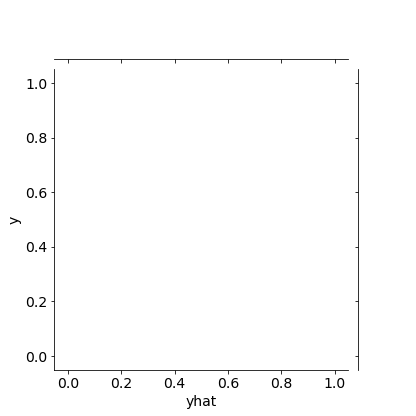

In [25]:
model = {}
forecast = {}

version = 15

wls = pd.read_pickle(file_place+"raw_hydrograph_data.pickle")
wls_piv = pd.read_pickle(file_place+"pivotedwells.pickle")
sntlhrly = pd.read_pickle(file_place+"wheeler_snotel.pickle")

comb_data = wls_piv#.resample('1H').mean().interpolate(method='time')
comb_data = comb_data['2010-10-01':'2019-08-07']

for col in comb_data.columns:
    if 'wle' in col:
        df = comb_data.rename(columns={col:'y'})
        df = df.dropna(subset=['y'])
        df.index.name = 'datetime'
        df.index = pd.to_datetime(df.index)
        df['month'] = df.index.month
        
        def is_evp_season(x):
            return (x < 10 or x > 3)

        df['on_season'] = df['month'].apply(lambda x: is_evp_season(x),1)
        df['off_season'] = ~df['month'].apply(lambda x: is_evp_season(x),1)
        data_train, data_test = utils.prepare_data(df, 2017)
        
        m = Prophet(daily_seasonality=False, weekly_seasonality=False)
        m.add_seasonality(name='daily_on_season', period=24, fourier_order=3, condition_name='on_season')
        m.add_seasonality(name='daily_off_season', period=24, fourier_order=3, condition_name='off_season')
       
        m.fit(data_train)

        future = m.make_future_dataframe(periods=len(data_test), freq='1D')
        futures = future.copy() 
        futures.index = pd.to_datetime(futures.ds)
        futures = futures.merge(df, left_index=True, right_index=True)
        futures = futures.reset_index(drop = True)
        
        forecast[col] = m.predict(futures)
        
        verif = utils.make_verif(forecast[col], data_train, data_test)
        fig1 = plot_verif(verif)
        plt.ylabel('Water Elevation (ft)')
        fig1.savefig(file_place+f"prophet_{col}_hourly_subdail_verif_v{version}.pdf")
        plt.close()
        
        fig2 = m.plot_components(forecast[col])
        fig2.savefig(file_place+f"prophet_comp_{col}_hourly_subdail_v{version}.pdf")
        plt.close()
        
        model[col] = m
        try:
            fig3 = plot_joint_plot(verif.loc['2017':,['yhat','y']].dropna(), title=col)
            fig3.savefig(file_place+f"prophet_joint_{col}_hourly_subdail_v{version}.pdf")
            plt.close()
        except:
            pass
        
        forecast[col].to_pickle(file_place+f'{col}_forecast_hourly_subdail_v{version}.pickle')
        print(col)

### Hourly With Regressor

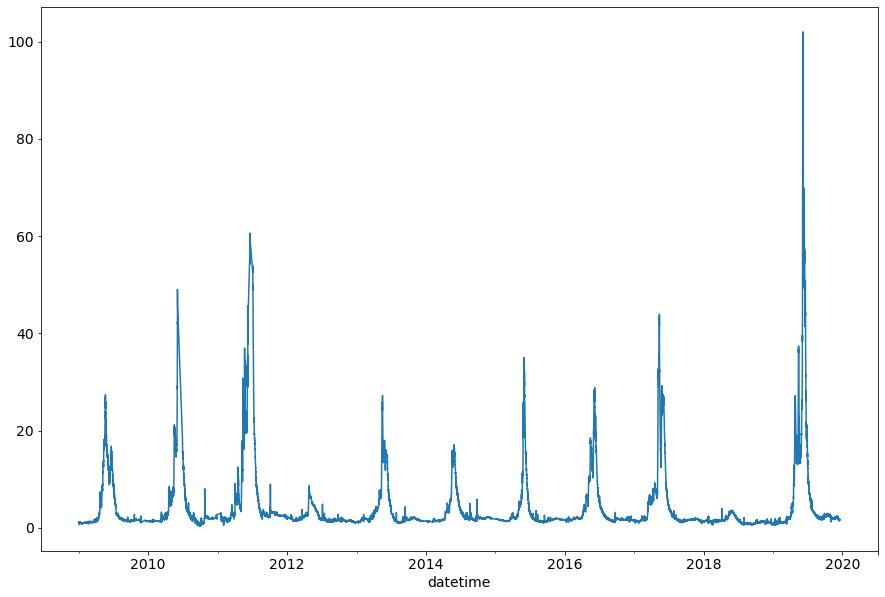

In [38]:
trout_hr['Q_cfs'].plot()

SG25A_wle
SG25B_wle
SG25C_wle
SG25D_wle
1011_wle
1012_wle
1013_wle
1014_wle
1016_wle


C:\Users\paulinkenbrandt\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\numpy\lib\histograms.py:898: RuntimeWarning:

invalid value encountered in true_divide



1017_wle
1019_wle
1020_wle


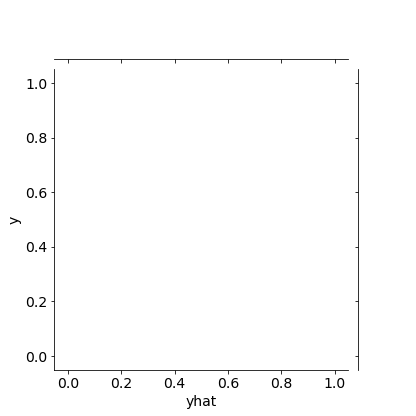

In [26]:
model = {}
forecast = {}
version = 14

wls = pd.read_pickle(file_place+"raw_hydrograph_data.pickle")
wls_piv = pd.read_pickle(file_place+"pivotedwells.pickle")
sntlhrly = pd.read_pickle(file_place+"wheeler_snotel.pickle")
sntlhrly = sntlhrly.resample('1H').mean().interpolate(method='time').rename(columns={'Snow Depth (in)':'snd'})
sntlhrly['snd'] = sntlhrly['snd'].apply(lambda x: np.nan if x>100 or x<0 else x, 1).interpolate(method='time')


wlsntl = pd.concat([wls_piv,sntlhrly,trout_hr['Q_cfs']],axis=1)
comb_data = wlsntl
comb_data = comb_data['2010-10-01':'2019-08-07']

for col in comb_data.columns:
    if 'wle' in col:
        df = comb_data.rename(columns={col:'y'})
        df = df.dropna(subset=['y','snd'])
        df.index.name = 'datetime'
        data_train, data_test = utils.prepare_data(df, 2017)
        m = Prophet(weekly_seasonality=False)
        m.add_regressor('snd')      
        m.fit(data_train)
        
        future = m.make_future_dataframe(periods=len(data_test), freq='1D')
        futures = future.copy() 
        futures.index = pd.to_datetime(futures.ds)
        futures = futures.merge(df, left_index=True, right_index=True)
        futures = futures.reset_index(drop = True)

        forecast[col] = m.predict(futures)
        
        verif = utils.make_verif(forecast[col], data_train, data_test)
        
        fig1 = plot_verif(verif)
        plt.ylabel('Water Elevation (ft)')
        fig1.savefig(figure_place+f"prophet_{col}_hourly_verif_reg_v{version}.pdf")
        plt.close()
        
        fig2 = m.plot_components(forecast[col])
        fig2.savefig(figure_place+f"prophet_comp_{col}_hourly_reg_v{version}.pdf")
        plt.close()
        
        model[col] = m
        
        try:
            fig3 = plot_joint_plot(verif.loc['2017':,['yhat','y']].dropna(), title=col)
            fig3.savefig(figure_place+f"prophet_joint_{col}_hourly_reg_v{version}.pdf")
            plt.close()
        except:
            pass
        
        forecast[col].to_pickle(figure_place+f'{col}_forecast_hourly_reg_v{version}.pickle')
        print(col)

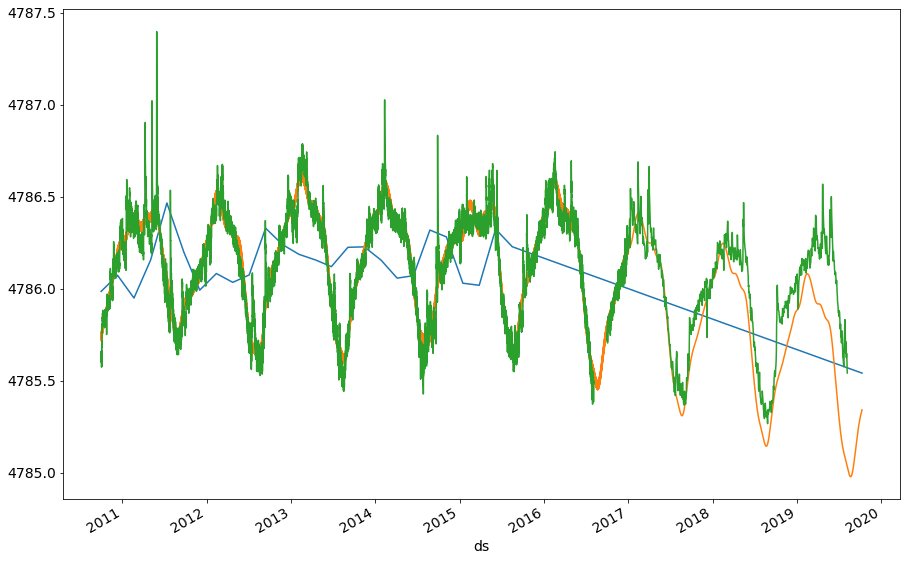

In [16]:
forecast_SG25A_wle.trend.plot()
forecast_SG25A_wle.yhat.plot()
forecast_SG25A_wle.y.plot()

## Daily

In [157]:
ugs_clim_raw_dly = pd.read_pickle(file_place + "ugs_clim_dly.pickle")

wls = pd.read_pickle(file_place+"raw_hydrograph_data.pickle")
st_mt_df = pd.read_pickle(file_place+'climate_station_metadata1.pickle')
prismloc = pd.read_pickle(file_place+'prism_local_SG25.pickle')
sntlhrly = pd.read_pickle(file_place+"wheeler_snotel.pickle")
trout_hr = pd.read_pickle(file_place + "trout_hrly.pickle")

### No Regressors

SG25A_wle
SG25B_wle
SG25C_wle
SG25D_wle
1011_wle
1012_wle
1013_wle
1014_wle
1015_wle
1016_wle


C:\Users\paulinkenbrandt\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\numpy\lib\histograms.py:898: RuntimeWarning:

invalid value encountered in true_divide



1017_wle
1019_wle
1020_wle


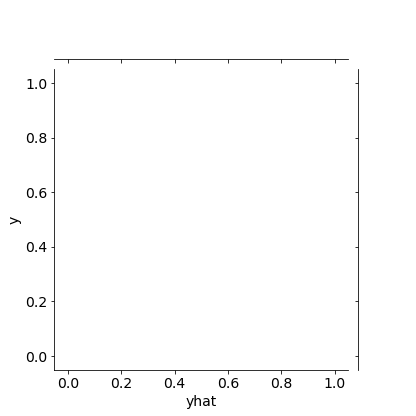

In [158]:
wls_piv = pd.read_pickle(file_place+"pivotedwells.pickle")
climate_data = pd.read_pickle(file_place+'climate_data.pickle')

comb_data_day = pd.concat([climate_data,wls_piv.resample('1D').mean()],axis=1)
comb_data_day = comb_data_day['2010-10-01':'2019-09-01']

noregres = proph_run(comb_data_day)

### Precip Predictor

SG25A_wle
SG25B_wle
SG25C_wle
SG25D_wle
1011_wle
1012_wle
1013_wle
1014_wle
1015_wle
1016_wle


C:\Users\paulinkenbrandt\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\numpy\lib\histograms.py:898: RuntimeWarning:

invalid value encountered in true_divide



1017_wle
1019_wle
1020_wle


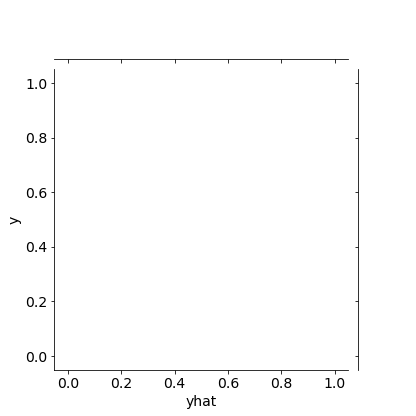

In [159]:
wls_piv = pd.read_pickle(file_place+"pivotedwells.pickle")
climate_data = pd.read_pickle(file_place+'climate_data.pickle')

comb_data_day = pd.concat([climate_data,wls_piv.resample('1D').mean()],axis=1)
comb_data_day = comb_data_day['2010-10-01':'2019-09-01']

regvar = 'partoun_ppt'

precipres = proph_run(comb_data_day,regvar='partoun_ppt')

### ET Predictor

SG25A_wle
SG25B_wle
SG25C_wle
SG25D_wle
1011_wle
1012_wle
1013_wle
1014_wle
1015_wle
1016_wle


C:\Users\paulinkenbrandt\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\numpy\lib\histograms.py:898: RuntimeWarning:

invalid value encountered in true_divide



1017_wle
1019_wle
1020_wle


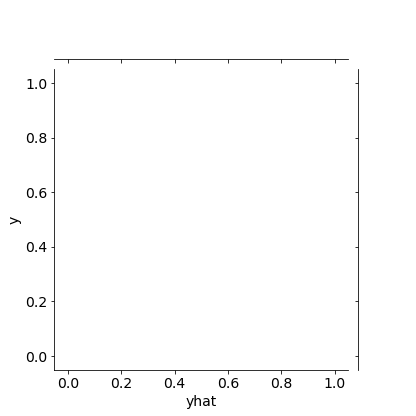

In [160]:
wls_piv = pd.read_pickle(file_place+"pivotedwells.pickle")
climate_data = pd.read_pickle(file_place+'climate_data.pickle')

comb_data_day = pd.concat([climate_data,wls_piv.resample('1D').mean()],axis=1)

etres = proph_run(comb_data_day,regvar='partoun_et')

### Maxtemp Predictor

SG25A_wle
SG25B_wle
SG25C_wle
SG25D_wle
1011_wle
1012_wle
1013_wle
1014_wle
1015_wle
1016_wle


C:\Users\paulinkenbrandt\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\numpy\lib\histograms.py:898: RuntimeWarning:

invalid value encountered in true_divide



1017_wle
1019_wle
1020_wle


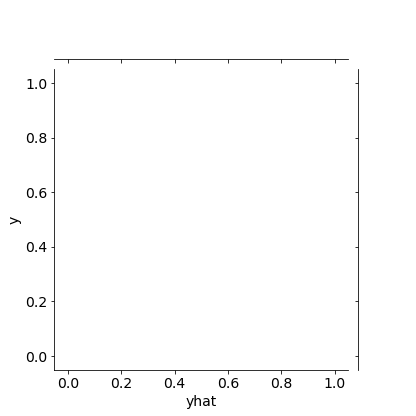

In [161]:
wls_piv = pd.read_pickle(file_place+"pivotedwells.pickle")
climate_data = pd.read_pickle(file_place+'climate_data.pickle')

comb_data_day = pd.concat([climate_data,wls_piv.resample('1D').mean()],axis=1)

maxtempres = proph_run(comb_data_day,regvar='partoun_maxtemp')


### Trout Predictor

In [162]:
trout_creek = "https://waterdata.usgs.gov/nwis/inventory?agency_code=USGS&site_no=10172870"
flow_data = wa.nwis('dv',[10172870],'sites')
trout = flow_data.data
trt = trout.rename(columns={'value':'trout'})['trout'].to_frame().resample('1D').mean().interpolate(method='time')
trt

wls_piv = pd.read_pickle(file_place+"pivotedwells.pickle")

comb_data_day = pd.concat([wls_piv.resample('1D').mean(),trt],axis=1)

connection successful


SG25A_wle
SG25B_wle
SG25C_wle
SG25D_wle
1011_wle
1012_wle
1013_wle
1014_wle
1015_wle
1016_wle


C:\Users\paulinkenbrandt\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\numpy\lib\histograms.py:898: RuntimeWarning:

invalid value encountered in true_divide



1017_wle
1019_wle
1020_wle


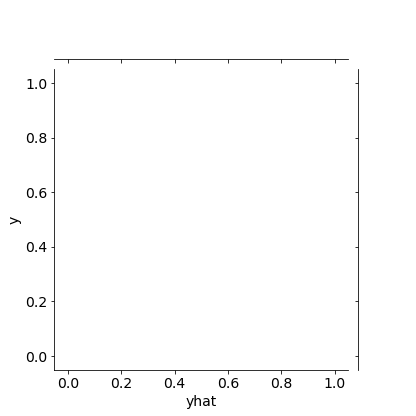

In [163]:
troutres = proph_run(comb_data_day,regvar='trout')



### Daily Summary

In [164]:
resultdfs = {'No reg':noregres.set_index('well'), 
             'Trout':troutres.set_index('well'),
             'Temp':maxtempres.set_index('well'), 
             'ET':etres.set_index('well'), 
             'Precip':precipres.set_index('well')}
pd.concat(resultdfs,axis=1).to_clipboard()

In [168]:
samprate = '1D'
regvars = ['partoun_maxtemp','partoun_et','partoun_ppt','trout','noreg']
vers = 6
file_place = "G:/My Drive/WORK/Leland_Harris/prophet_out/"
verif = {}
forecast = {}


for col in comb_data_day:
    if '_wle' in col and col not in ('1066_wle','1061_wle'):
        for regvar in regvars:

            verif[col+'_'+regvar] = pd.read_pickle(file_place+f'prophet_{col}_verify_{samprate}_{regvar}_v{vers}.pickle')
            forecast[col+'_'+regvar] = pd.read_pickle(file_place+f'prophet_{col}_forecast_{samprate}_{regvar}_v{vers}.pickle')
 

# Validation

C:\Users\paulinkenbrandt\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



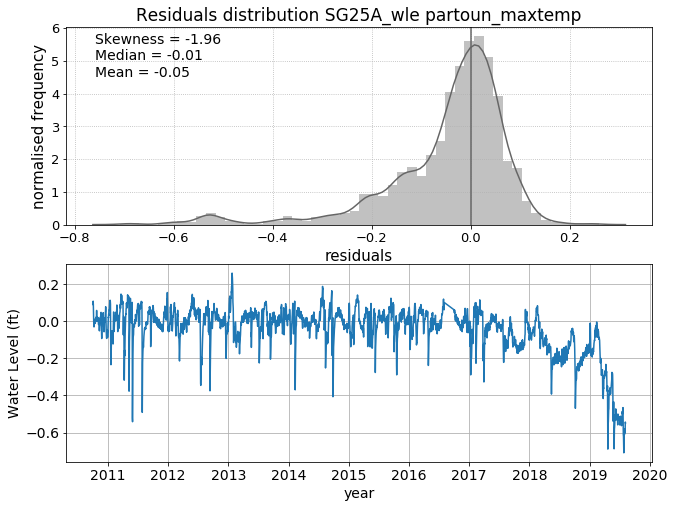

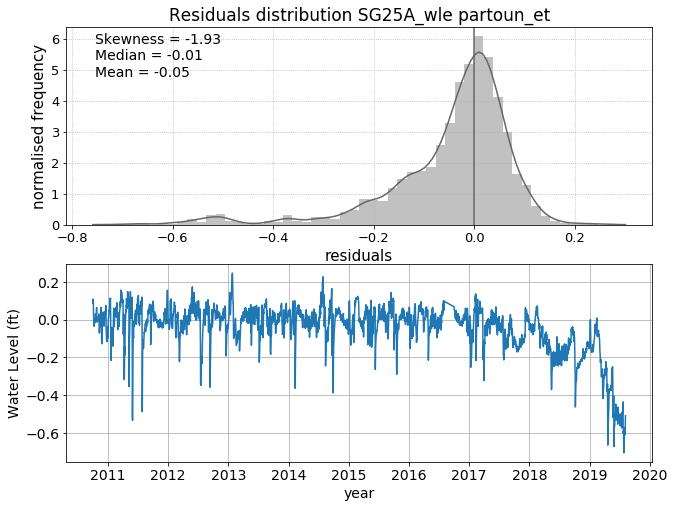

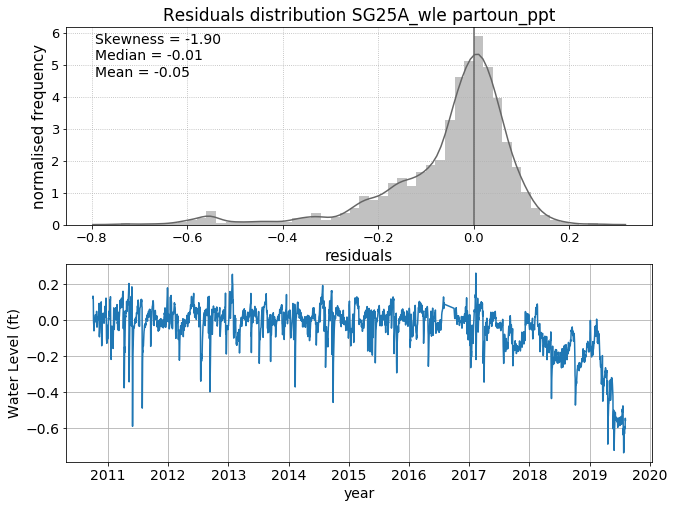

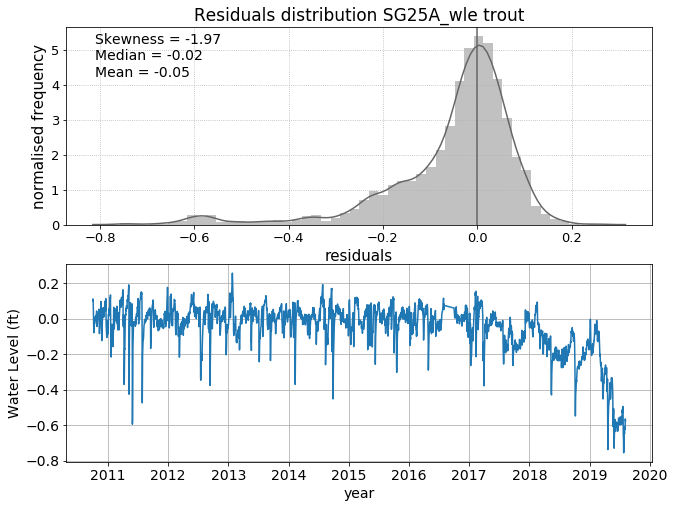

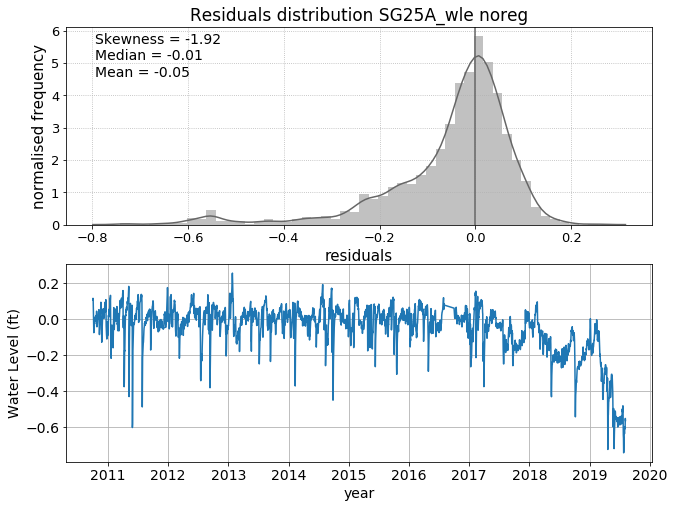

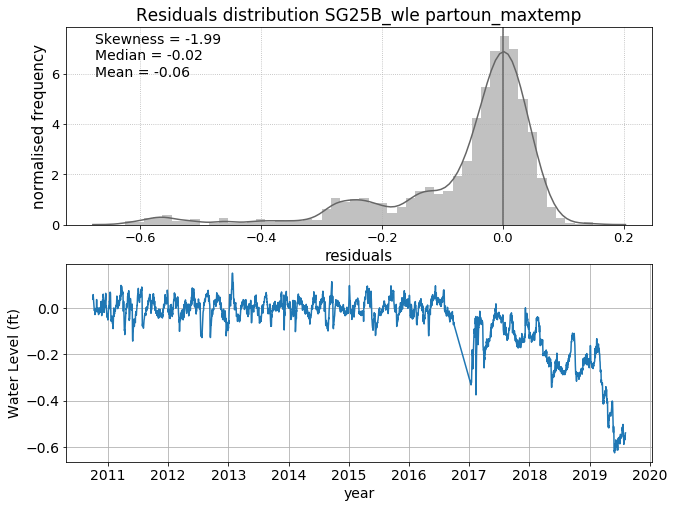

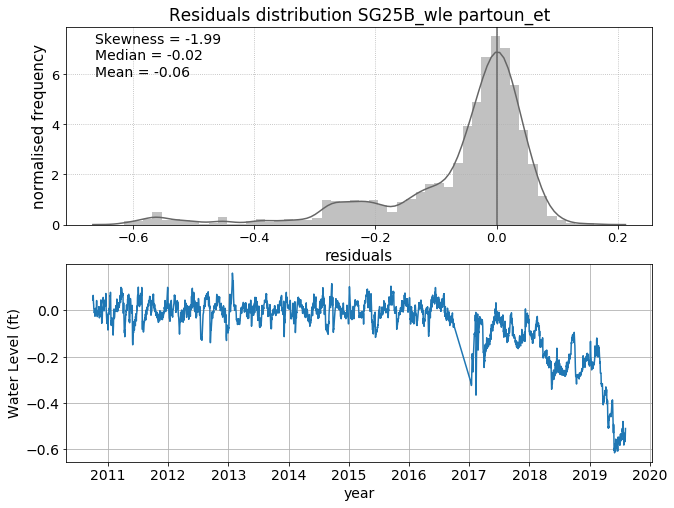

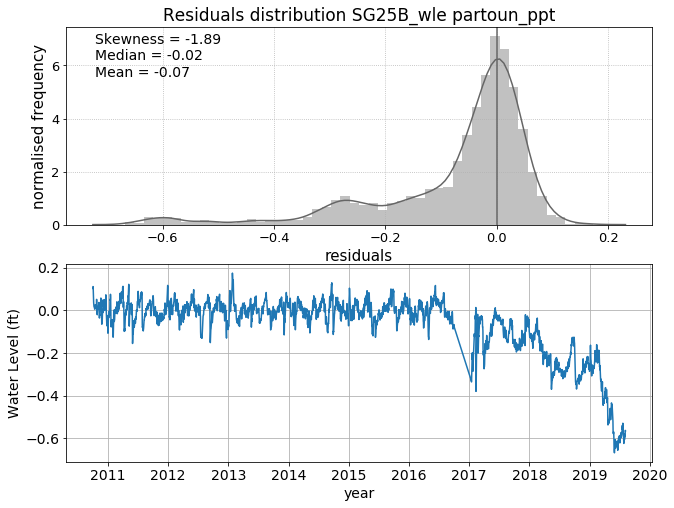

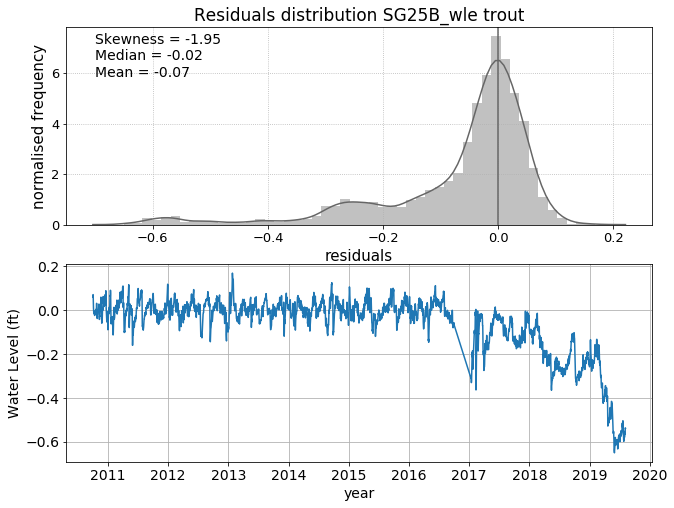

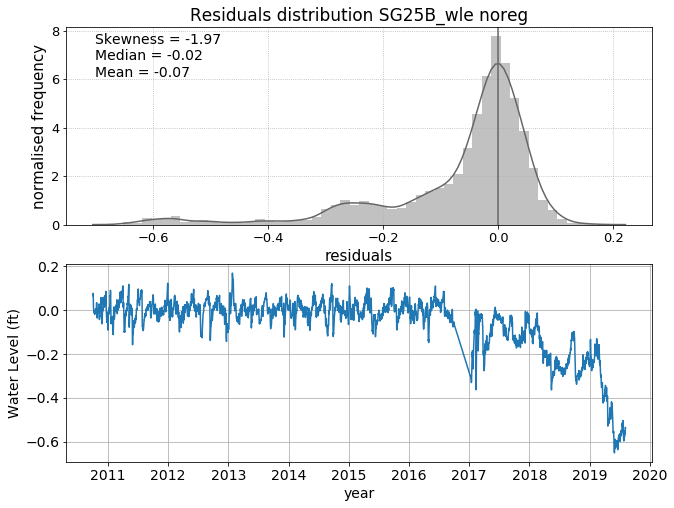

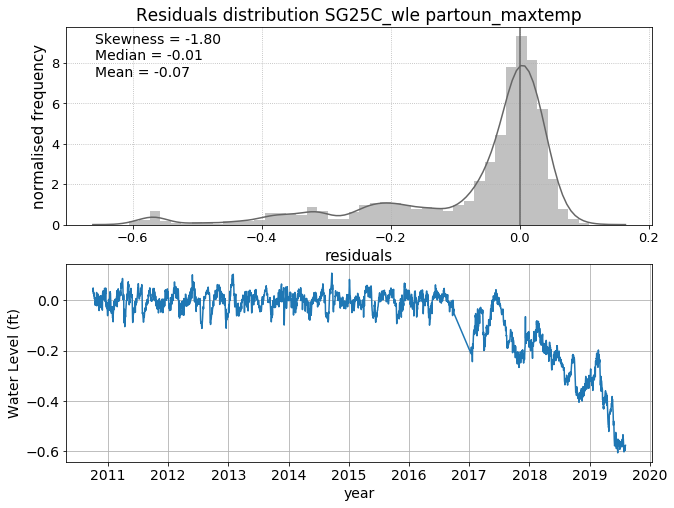

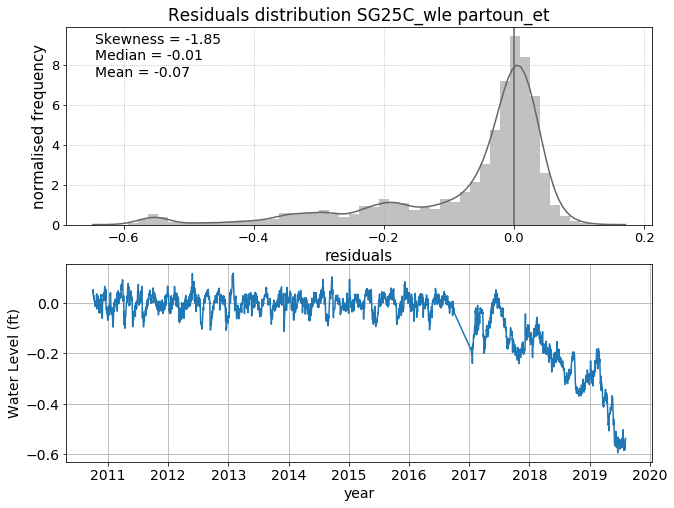

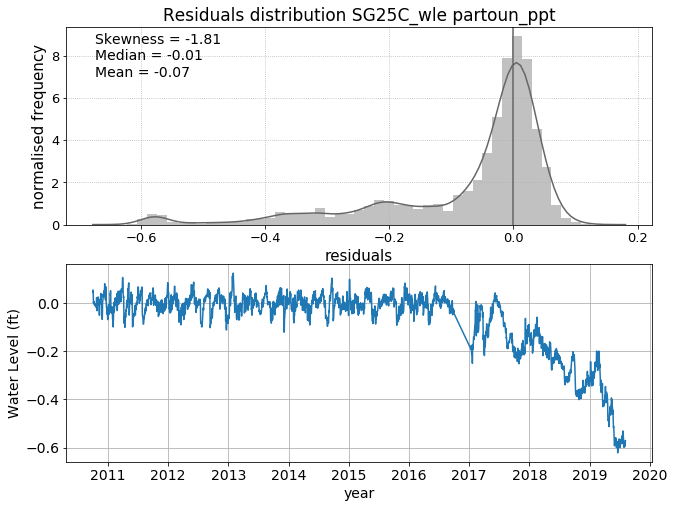

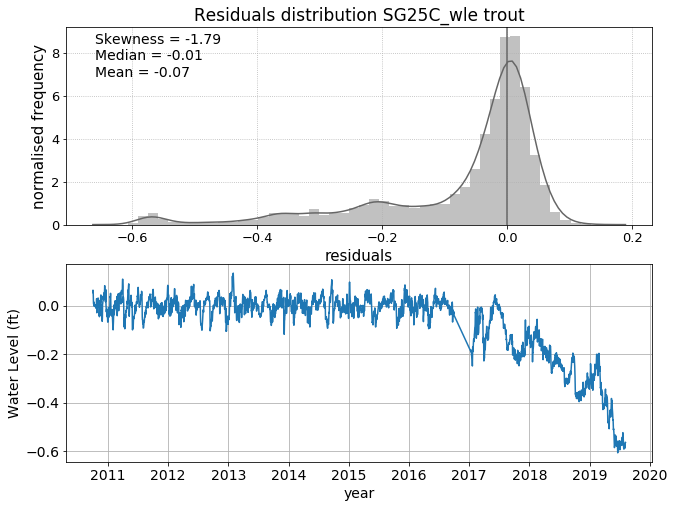

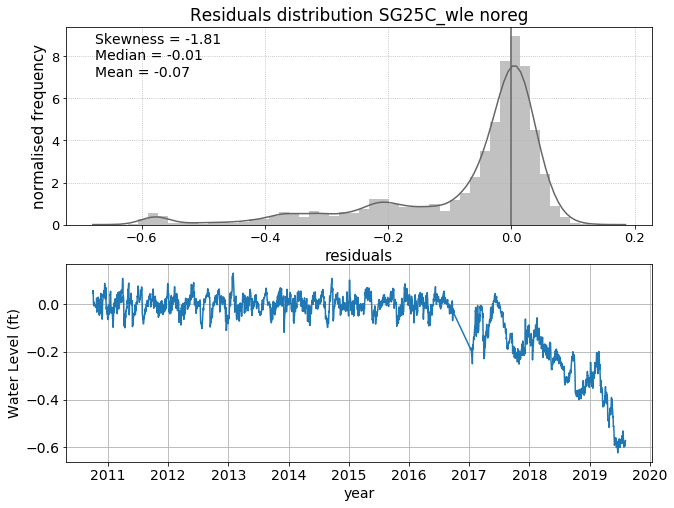

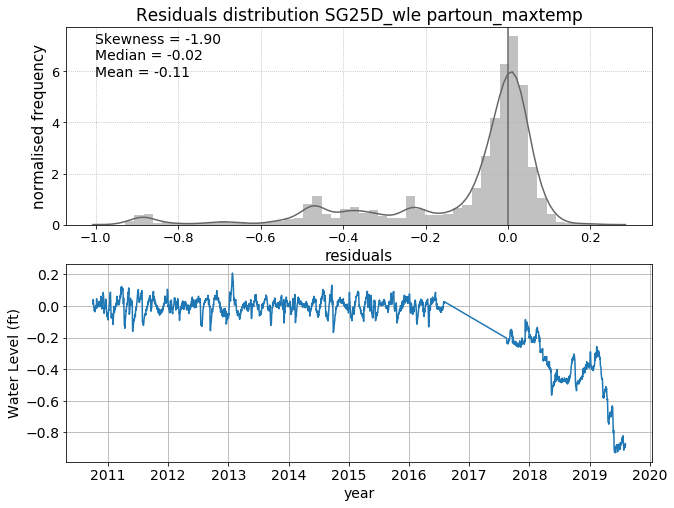

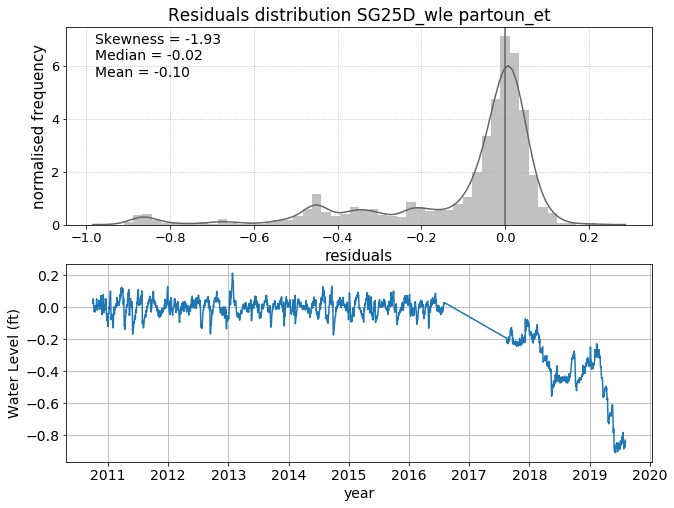

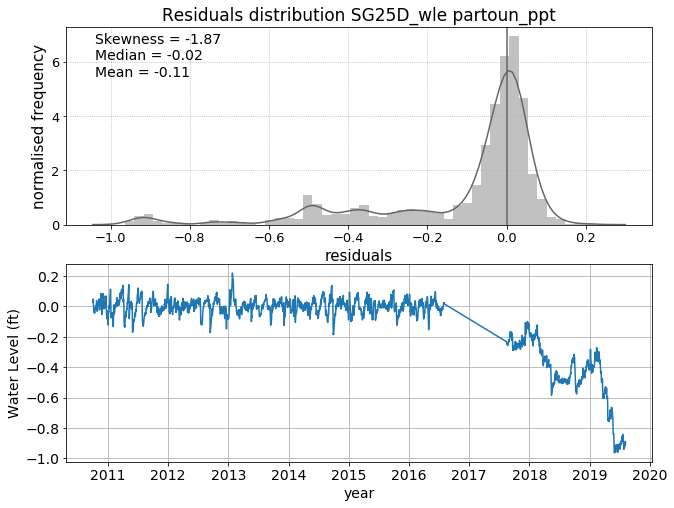

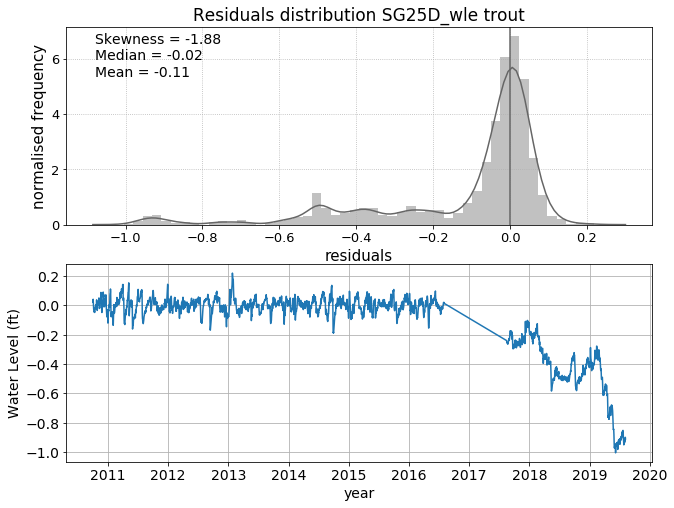

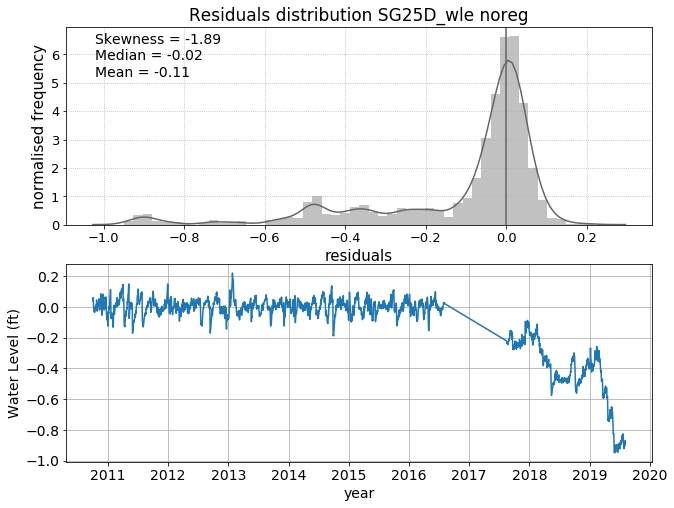

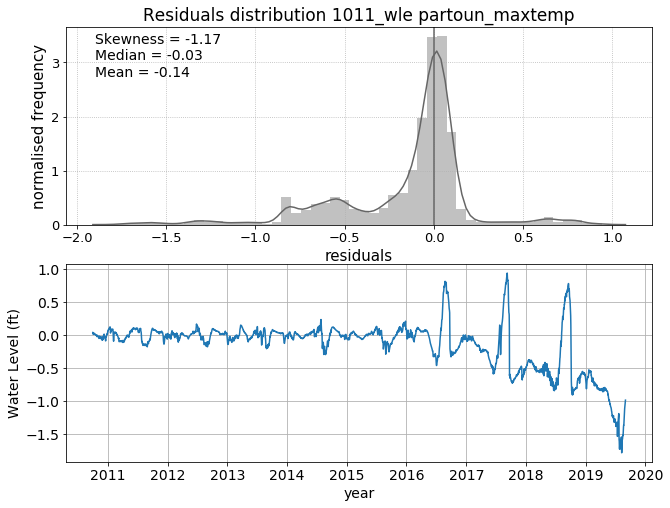

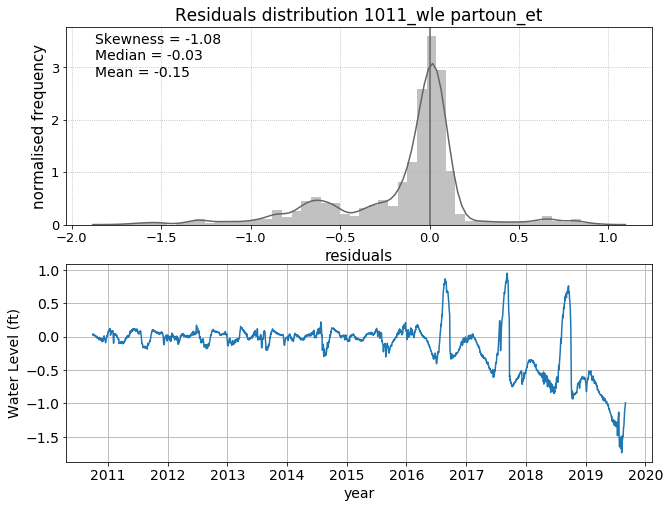

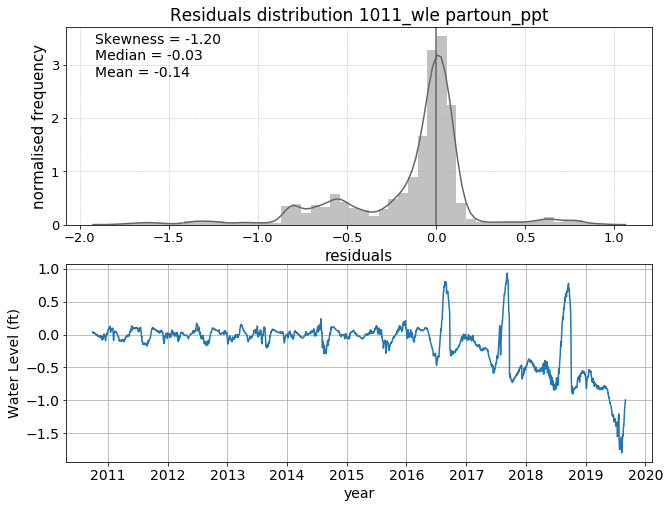

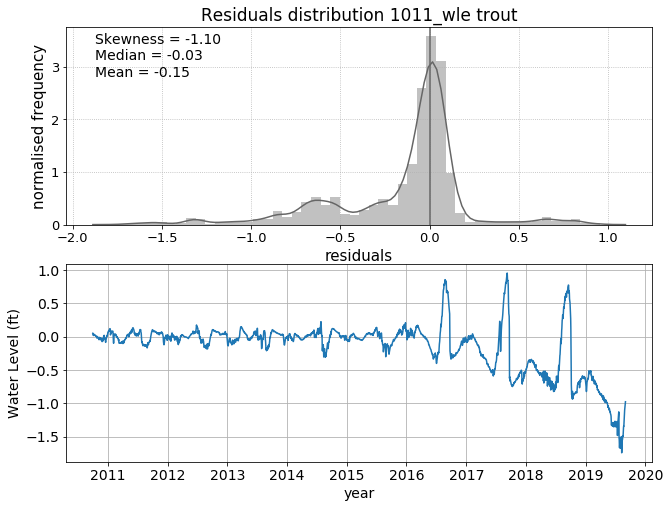

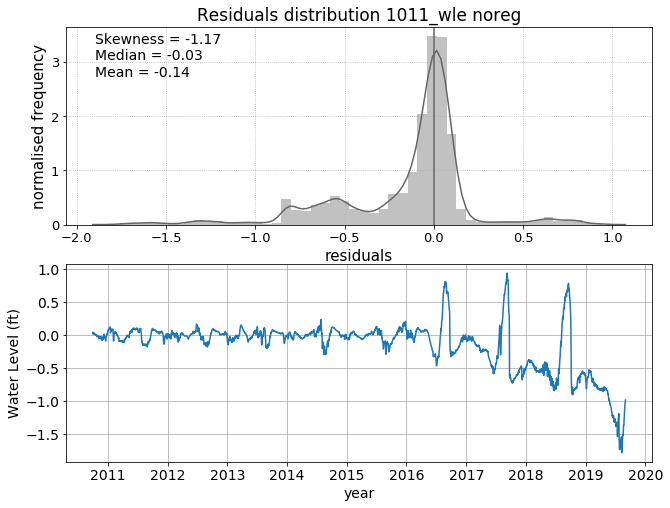

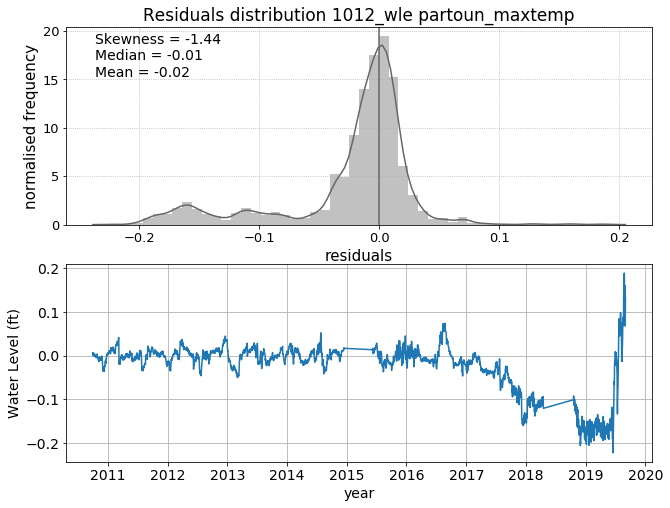

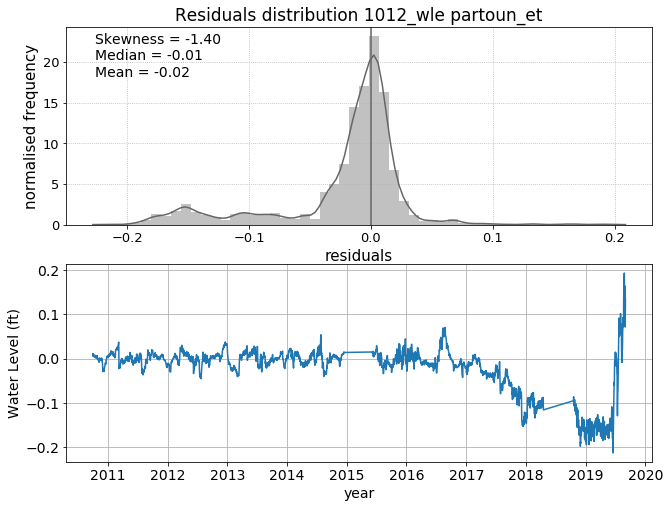

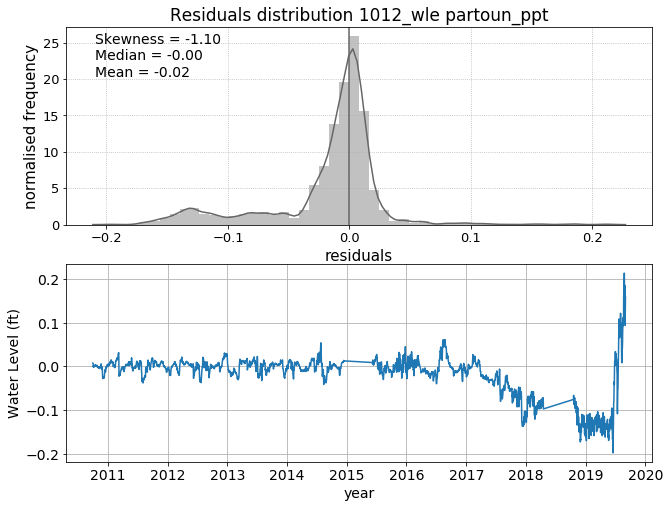

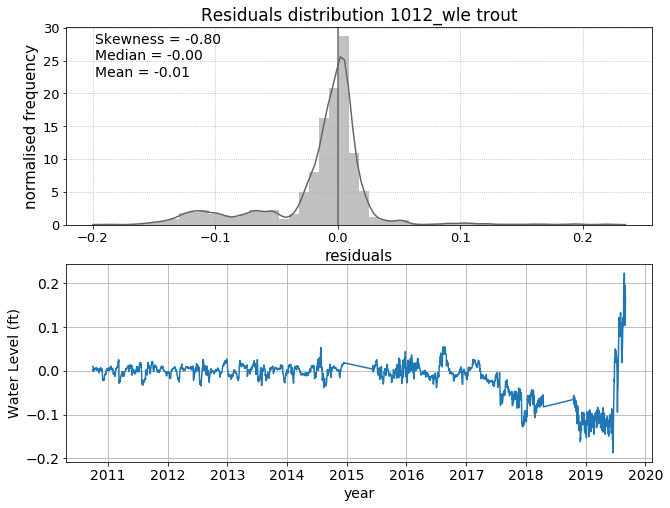

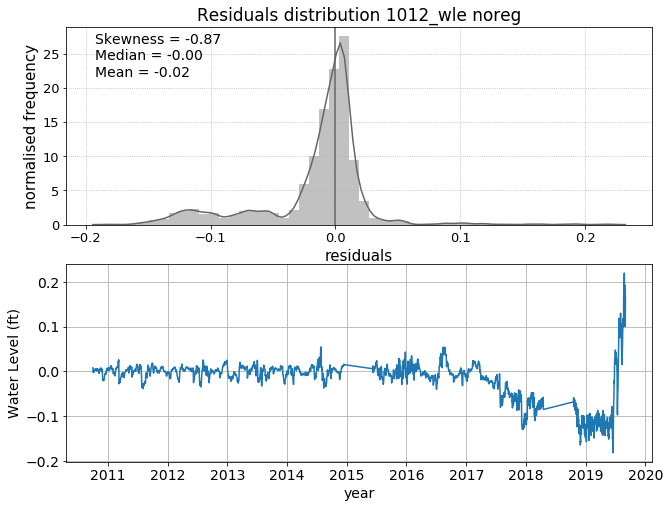

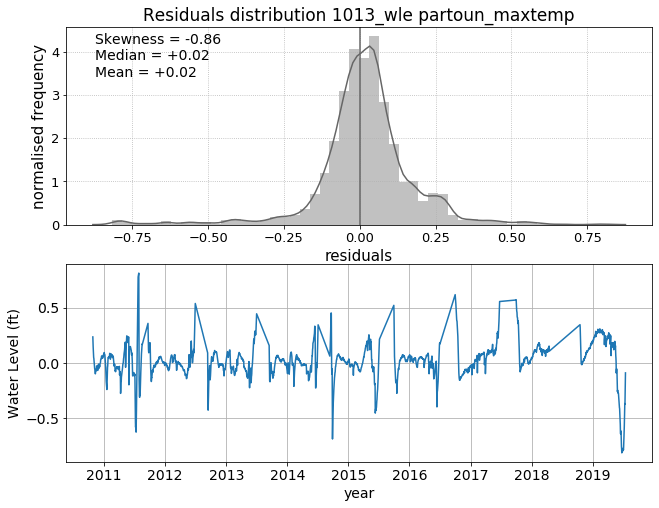

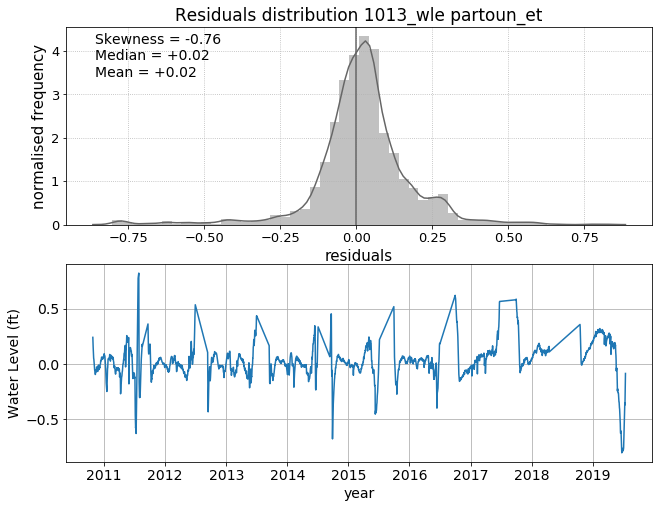

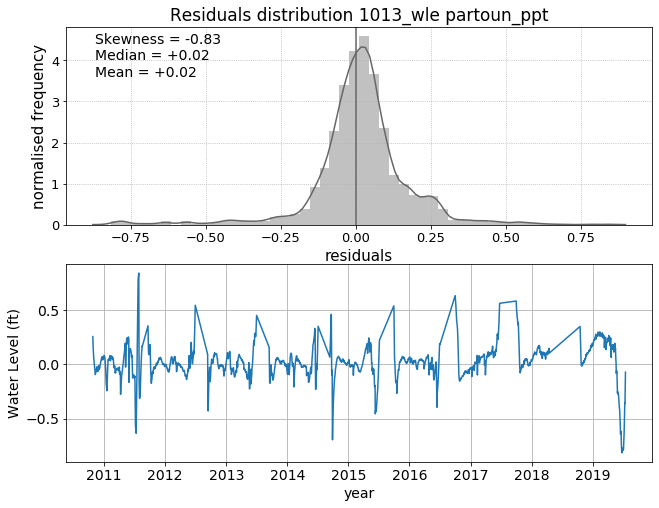

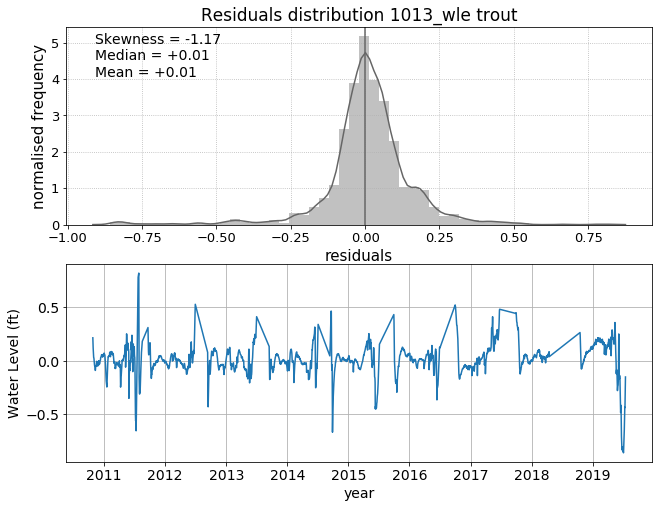

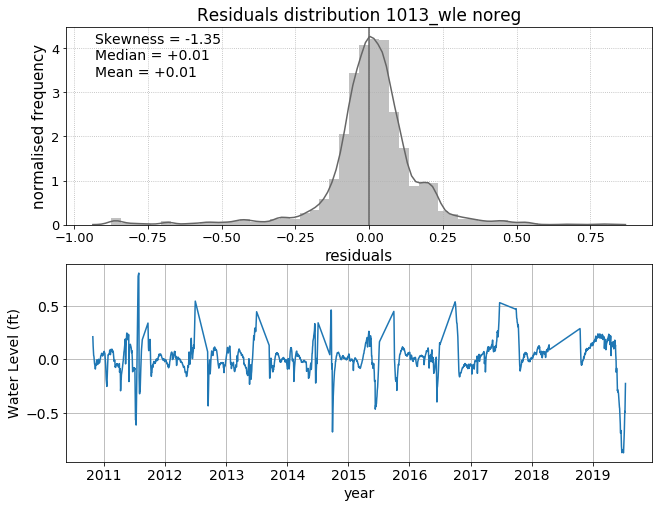

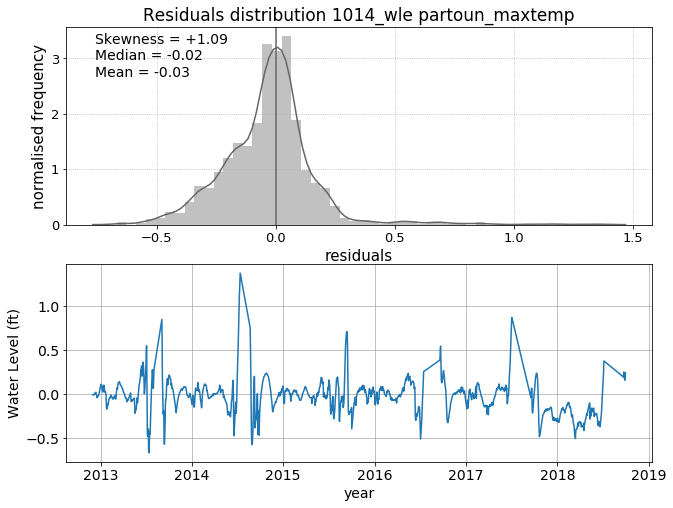

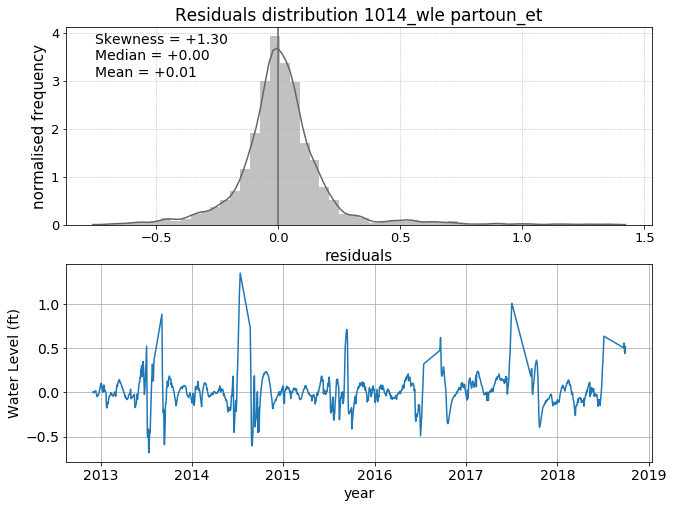

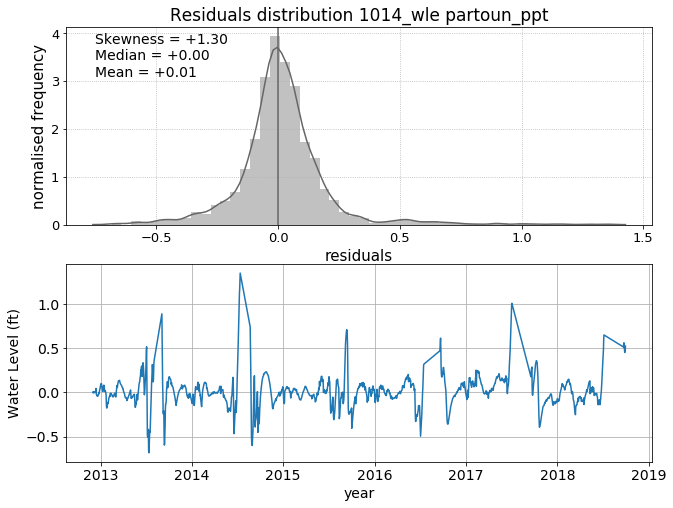

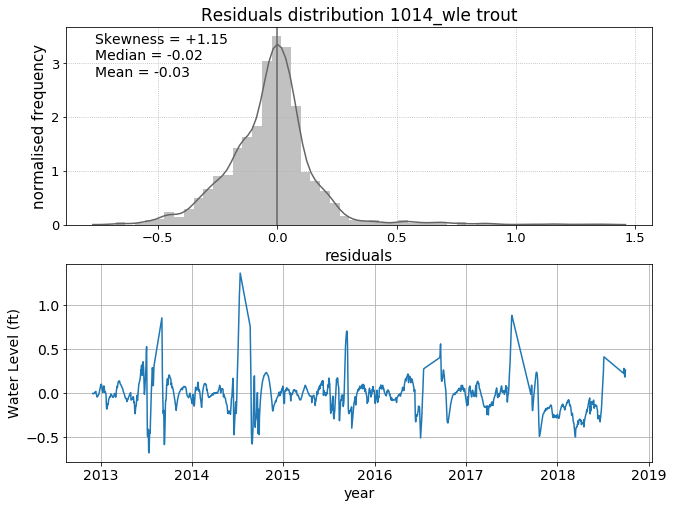

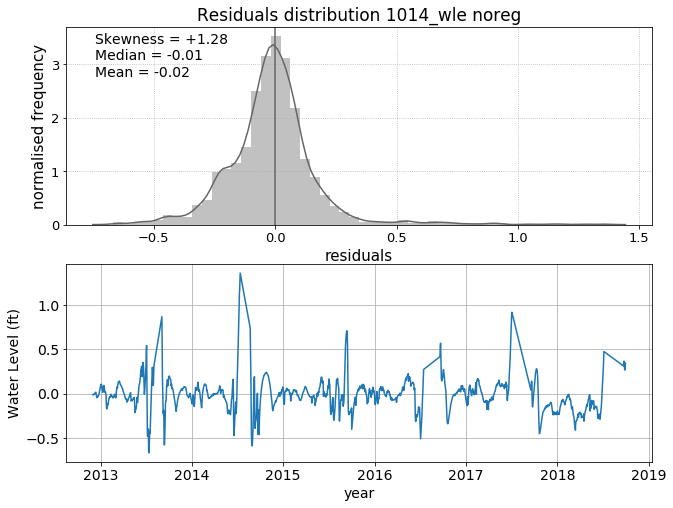

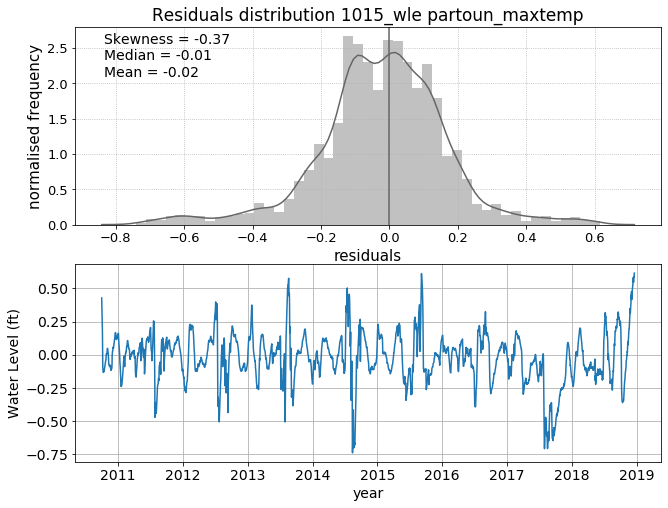

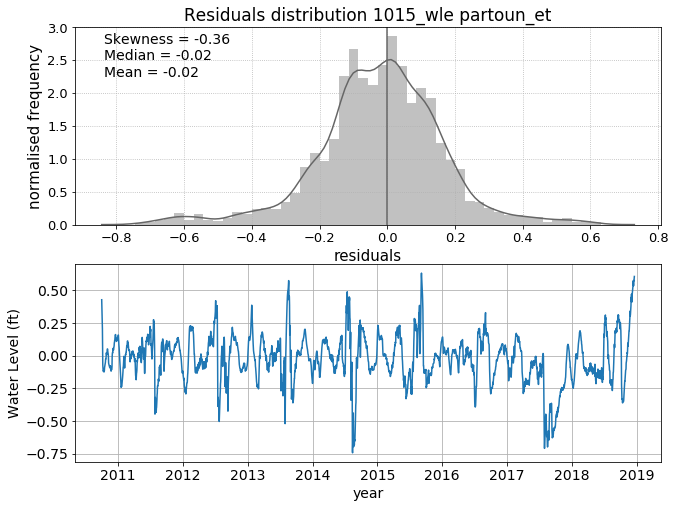

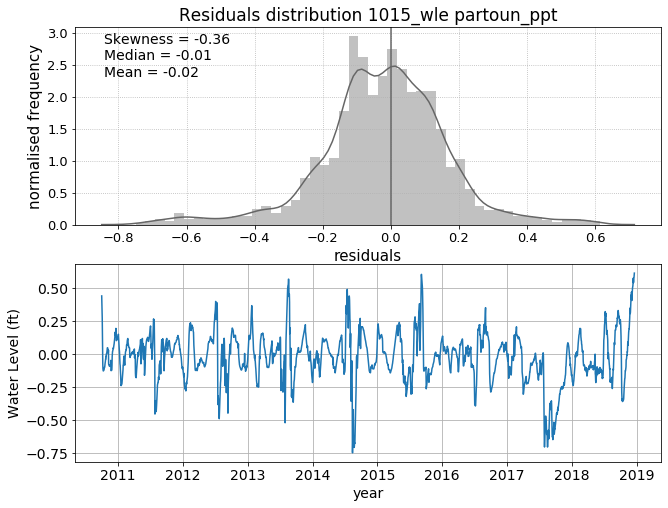

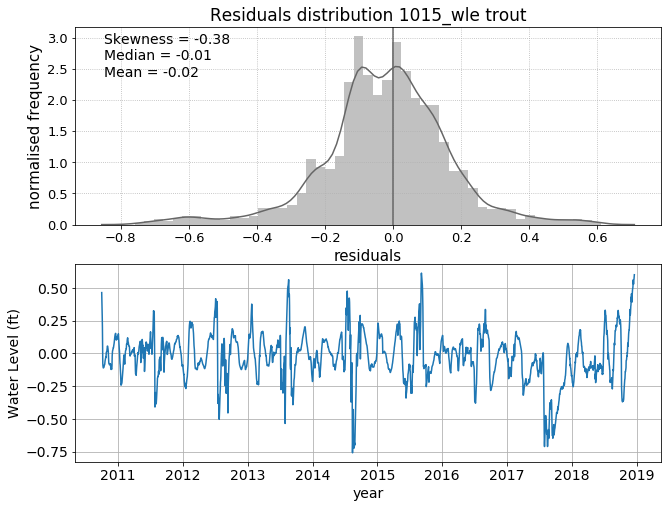

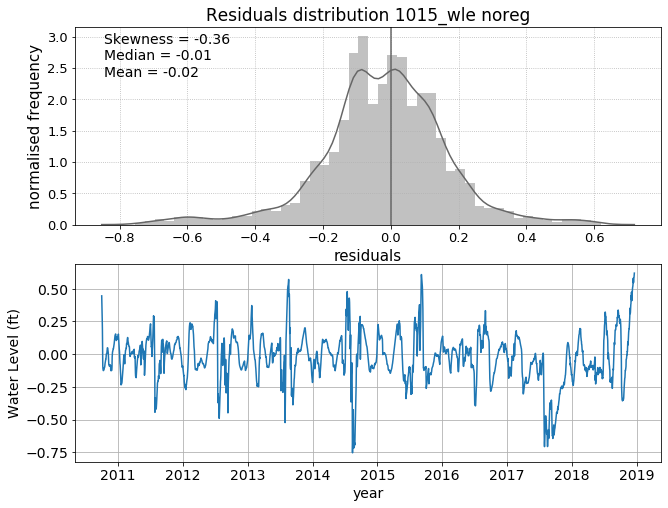

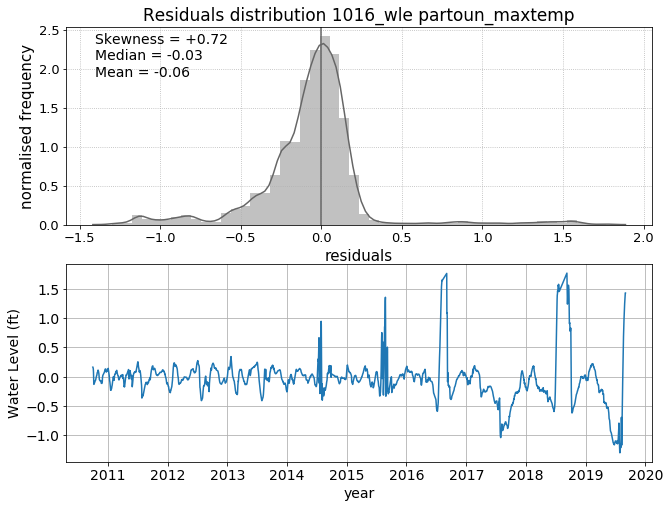

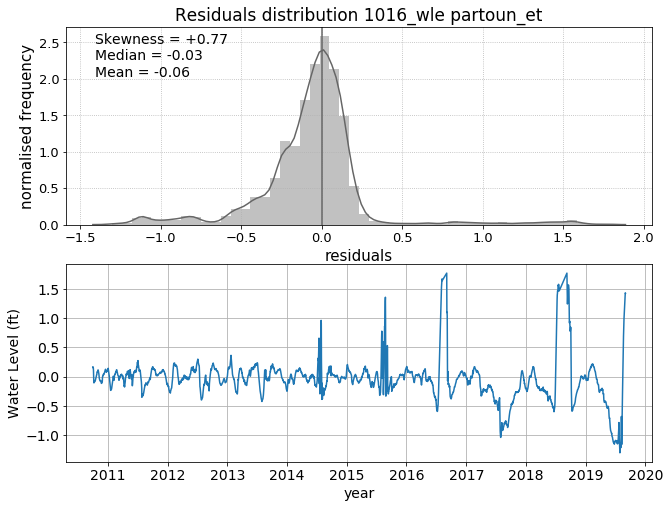

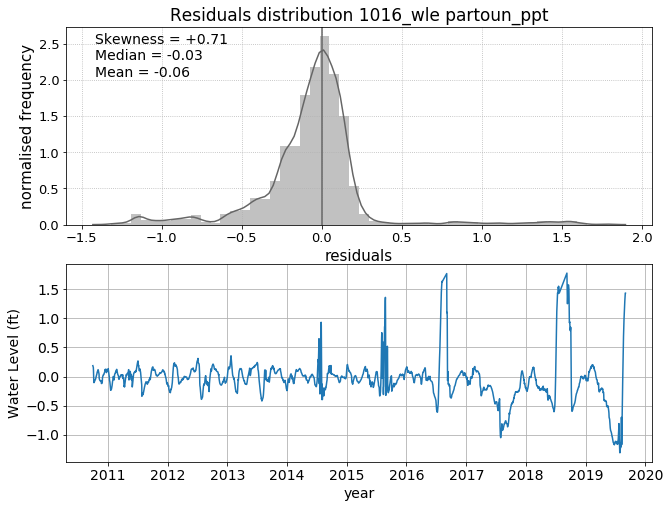

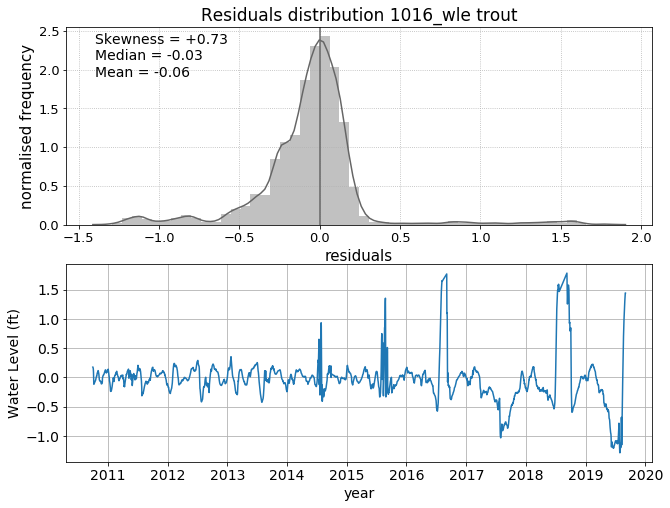

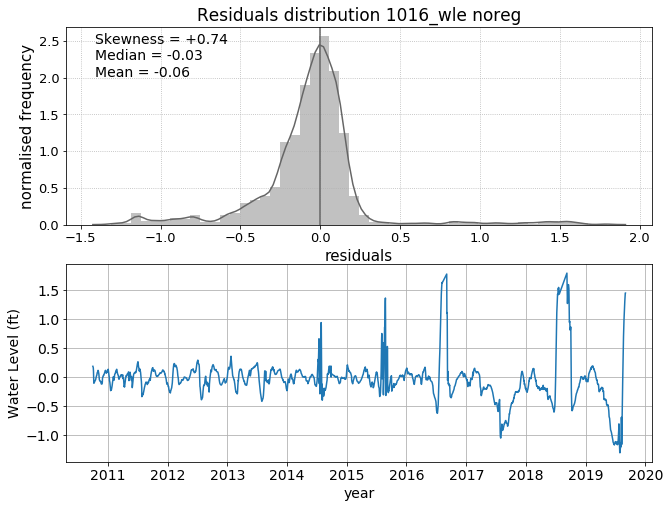

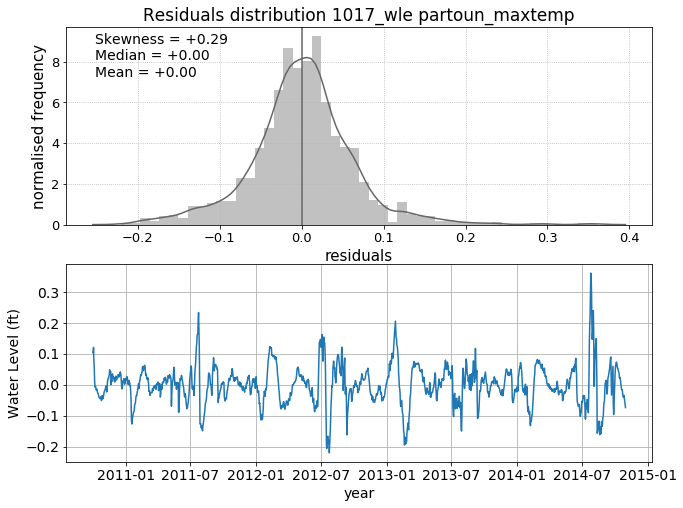

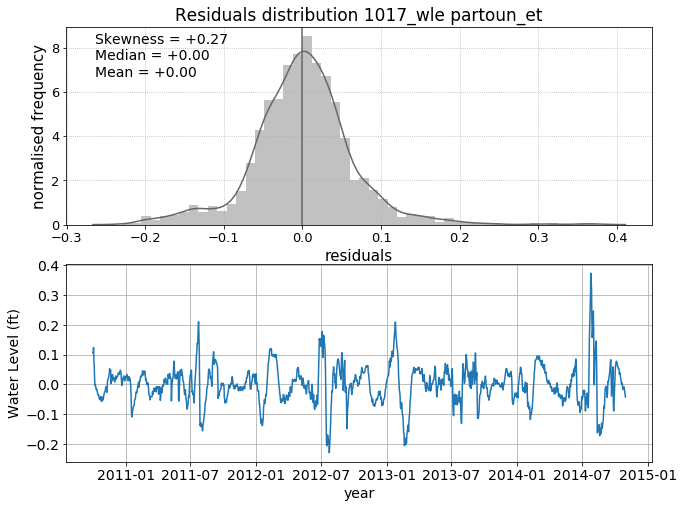

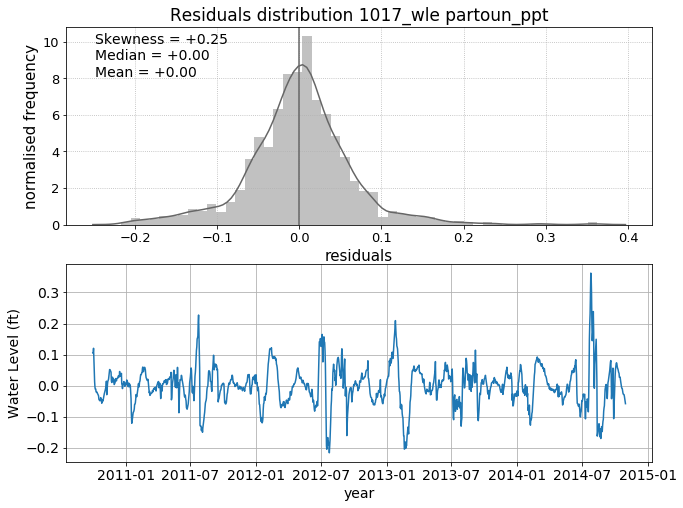

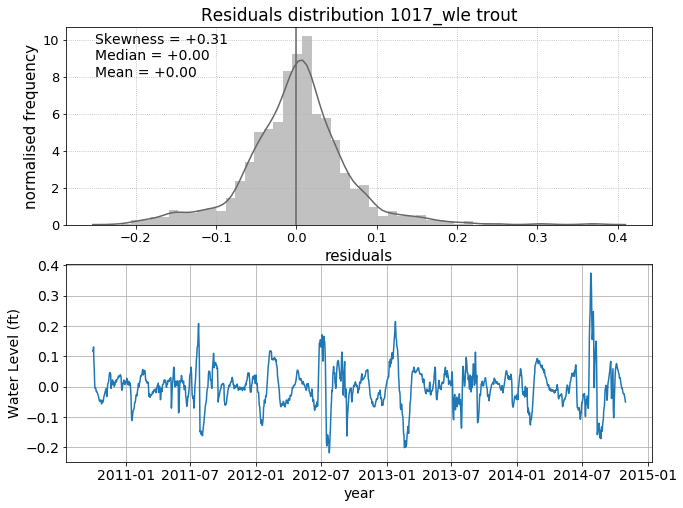

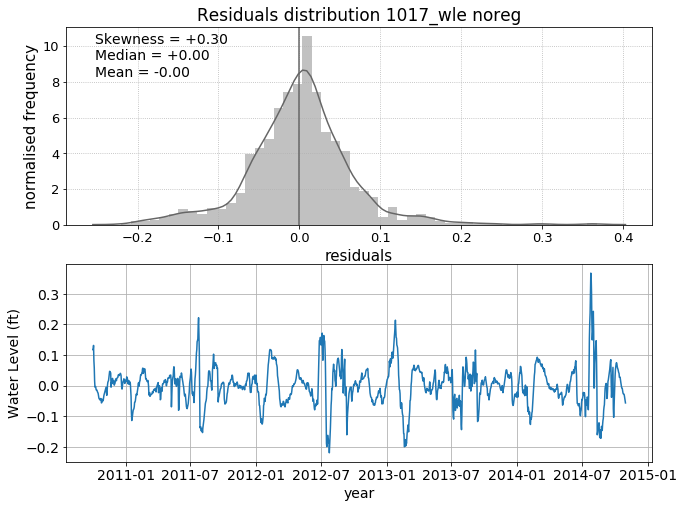

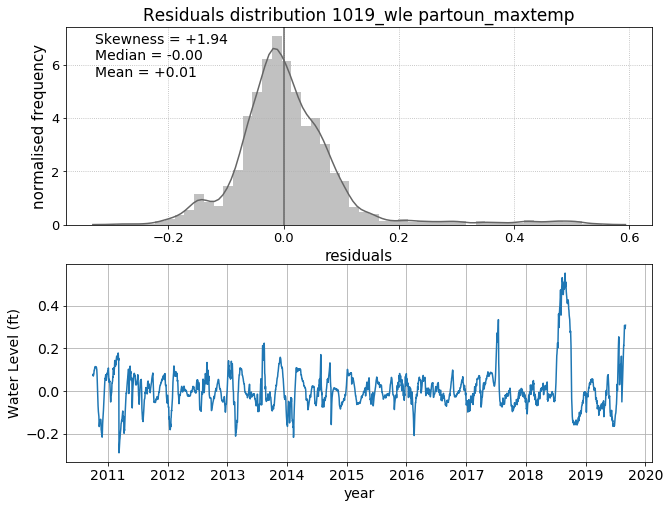

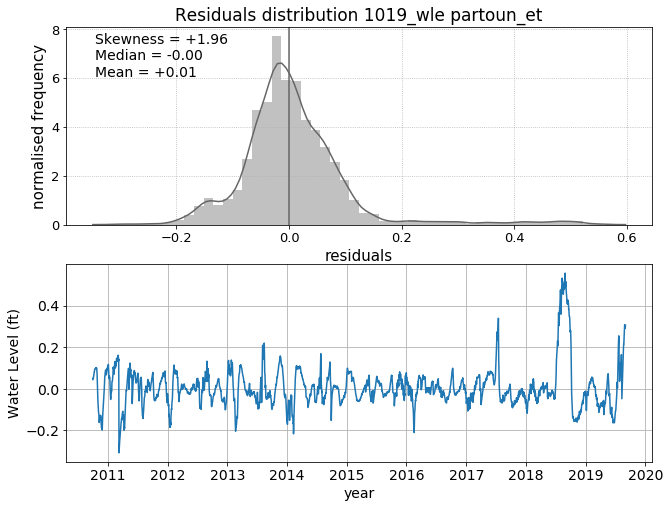

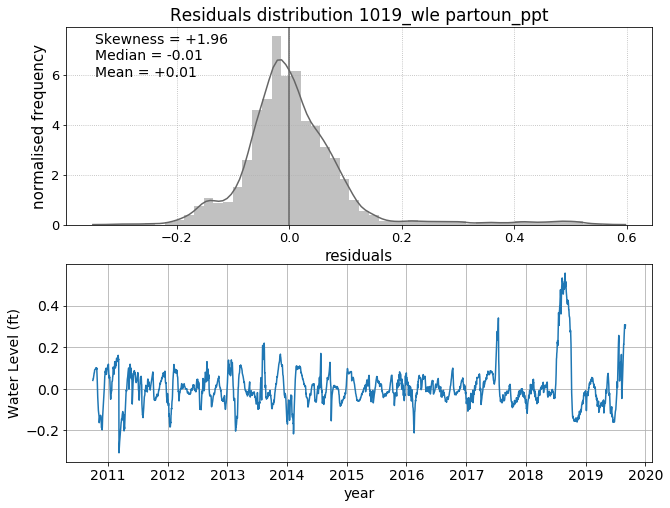

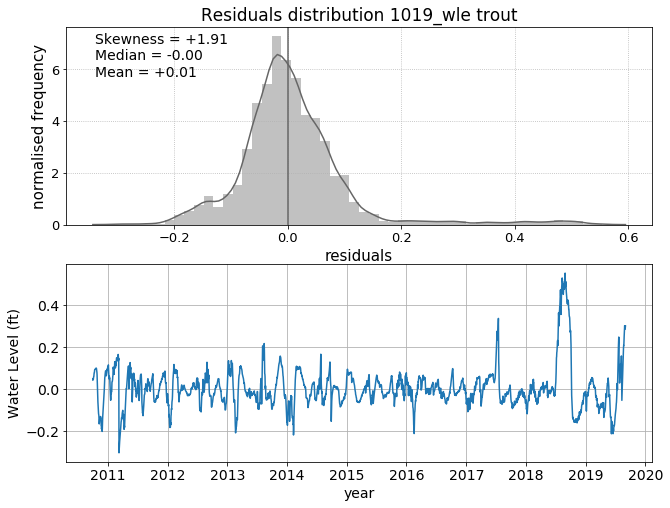

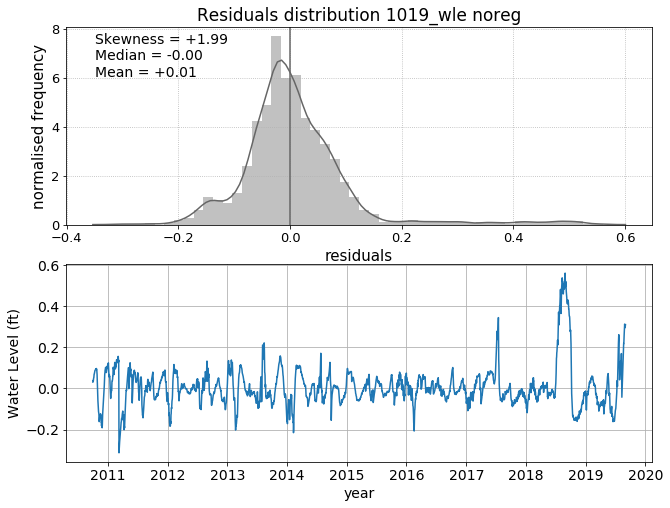

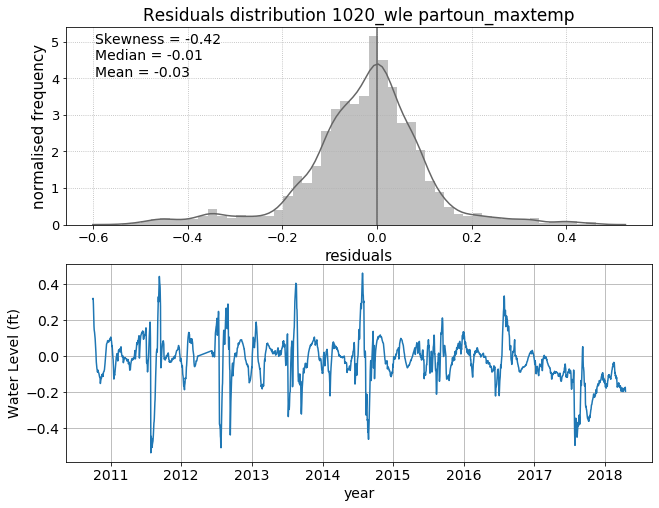

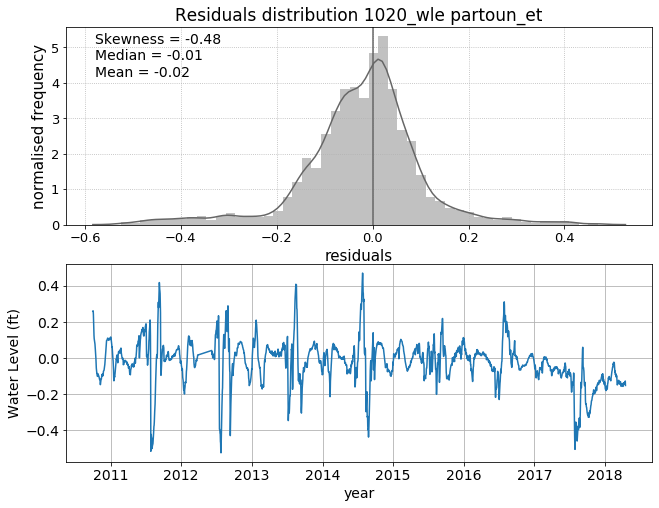

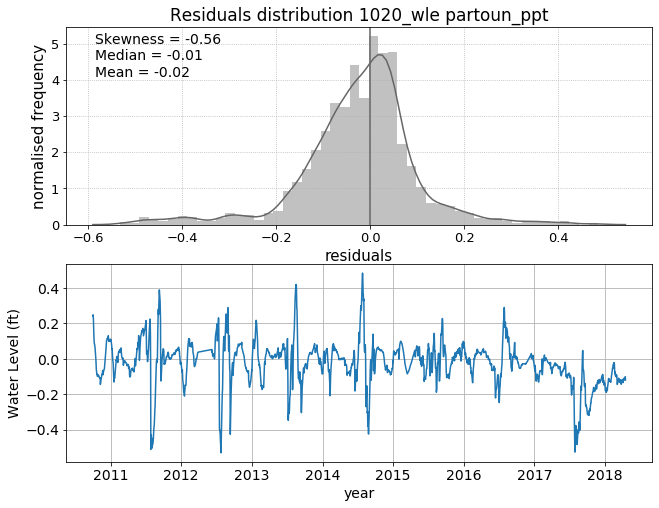

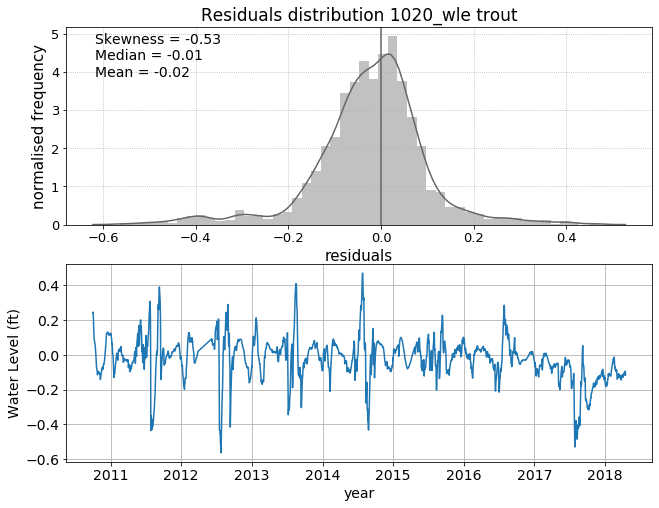

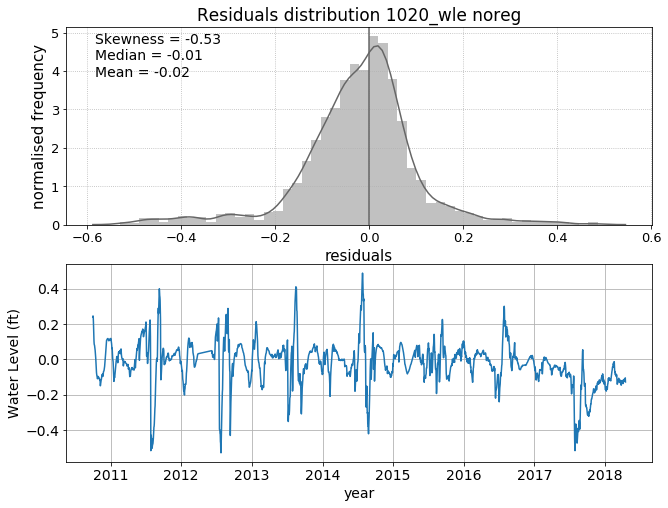

In [178]:
file_place = "G:/My Drive/WORK/Leland_Harris/prophet_out/"
regvars = ['partoun_maxtemp','partoun_et','partoun_ppt','trout','noreg']

resid = {}

for col in comb_data_day:
    if '_wle' in col and col not in ('1066_wle','1061_wle'):
        for regvar in regvars:
            df = verif[col+'_'+regvar].loc[:,['yhat','y']].dropna()
            residuals = df['yhat'] - df['y']

            f, ax = plt.subplots(2,1,figsize=(10.5,8))
            sns.distplot(residuals, ax=ax[0], color='0.4')
            ax[0].grid(ls=':')
            ax[0].set_xlabel('residuals', fontsize=15)
            ax[0].set_ylabel("normalised frequency", fontsize=15)
            ax[0].grid(ls=':')

            [l.set_fontsize(13) for l in ax[0].xaxis.get_ticklabels()]
            [l.set_fontsize(13) for l in ax[0].yaxis.get_ticklabels()];

            ax[0].axvline(0, color='0.4')

            ax[0].set_title(f'Residuals distribution {col} {regvar}', fontsize=17)

            ax[0].text(0.05, 0.75, "Skewness = {:+4.2f}\nMedian = {:+4.2f}\nMean = {:+4.2f}".\
                    format(skew(residuals), residuals.median(), residuals.mean()), \
                    fontsize=14, transform=ax[0].transAxes)

            ax[1].plot(residuals.index, residuals)
            ax[1].set_ylabel('Water Level (ft)')
            ax[1].set_xlabel('year')
            ax[1].grid(True)
            resid[col+'_'+regvar] = residuals
            plt.savefig(file_place + f"residuals_{col}_{regvar}.pdf")
            plt.close()

In [ ]:
z = 1
for key in list(forecast.keys())[0:4]:
    z += 1
    x = forecast[key].set_index('ds').index
    y = forecast[key].set_index('ds')['yhat']
    x1 = wls_piv[key].index
    y1 = wls_piv[key]
    plt.plot(x,y,label=key, zorder=z)
    plt.scatter(x1,y1,alpha=0.3,s=5, color= 'grey', zorder=0)
plt.legend()
plt.grid()

In [ ]:
z = 1
for key in list(forecast.keys())[0:4]:
    z += 1
    x = forecast[key].set_index('ds').index
    y = forecast[key].set_index('ds')['yhat']
    x1 = wls_piv[key].index
    y1 = wls_piv[key]
    plt.plot(x,y,label=key, zorder=z)
    plt.scatter(x1,y1,alpha=0.3,s=5, color= 'grey', zorder=0)
plt.legend()
plt.grid()

In [ ]:
station = 'USC00426708'
dfs = {}
for station in st_df.index.get_level_values(0).unique()[3:]:
    stname = st_mt_df.loc[station,'Station Name'].split(" ")[0].lower()

    dfs[station] = st_df.loc[station].dropna(axis=1,how='all').rename(columns={'Precipitation':f'{stname}_ppt',
                                                            'Snow Depth':f'{stname}_snowdpt',
                                                           'Snow Fall':f'{stname}_snowfall',
                                                           'Min Temperature':f'{stname}_mintemp',
                                                           'Max Temperature':f'{stname}_maxtemp',
                                                           'Ref Evapotranspiration':f'{stname}_et'})
    if 'Multi-Day Precipitation' in dfs[station].columns:
        dfs[station] = dfs[station].drop(['Multi-Day Precipitation'],axis=1)

In [ ]:
weatherdata = pd.concat(dfs, axis=1)#
weatherdata.columns = weatherdata.columns.droplevel(0)
for col in weatherdata.columns:
    if 'goshute' in col or 'silver' in col or 'baker' in col or 'wheeler' in col or 'ibapah' in col or 'great' in col:
        weatherdata = weatherdata.drop(col, axis=1)

In [ ]:
weatherdata.index = pd.to_datetime(weatherdata.index)

In [ ]:
for col in weatherdata.columns:
    if '_ppt' in col and 'silver' not in col and 'baker' not in col and 'wheeler' not in col:
        df = weatherdata.groupby(pd.Grouper(freq='6M')).sum()
        df = df.replace(0.0, np.nan)
        plt.plot(df.index[1:-1],df[col][1:-1], label=col)
plt.grid()
plt.legend()

In [ ]:
sntl = pd.read_pickle(file_place+'snotel_data.pickle')
for col in sntl.columns:
    if 'Salinity' in col or 'Battery' in col or 'Air Temperature' in col:
        sntl = sntl.drop(col,axis=1)

for col in sntl.columns:
    if 'Precipitation Accumulation' in col:
        sntl = sntl.rename(columns={col:col.split(" ")[0]+'_pptaccm_mm'})
    elif 'Precipitation Increment - Snow-adj' in col:
        sntl = sntl.rename(columns={col:col.split(" ")[0]+'_pptincr_mm'})
    elif 'Soil Moisture' in col:
        sntl = sntl.rename(columns={col:col.split(" ")[0]+col.split(" ")[6]+'_soilmoist_pct'})
    elif 'Soil Temperature' in col:
        sntl = sntl.rename(columns={col:col.split(" ")[0]+col.split(" ")[6]+'_soiltemp_C'})
    elif 'Snow Depth' in col:
        sntl = sntl.rename(columns={col:col.split(" ")[0]+'_snowdepth_cm'})
    elif 'Snow Water' in col:
        sntl = sntl.rename(columns={col:col.split(" ")[0]+'_swe_mm'})
    else:
        sntl = sntl.drop(col,axis=1)
sntl.index = pd.to_datetime(sntl.index)

In [ ]:
def climate_plotter(df, keyword, frq='6M',totaler='mean'):
    fig, ax = plt.subplots(1,1)
    for col in df.columns:
        if keyword in col:
            if totaler=='mean':
                df = df.groupby(pd.Grouper(freq=frq)).mean()
            elif totaler=='sum':
                df = df.groupby(pd.Grouper(freq=frq)).sum()
            else:
                df = df.groupby(pd.Grouper(freq=frq)).median()
            df = df.replace(0.0, np.nan)
            plt.plot(df.index,df[col], label=col)
    plt.grid()
    plt.legend()
    return fig, ax

In [ ]:
climate_plotter(climate_data,'maxtemp','1Y')

In [ ]:
rcParams['figure.figsize'] = 15, 10
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 14

y_reg = st_df.loc['USC00421144','Ref Evapotranspiration'].loc['2016-01-01':]
x_reg= st_df.loc['USC00421144','Ref Evapotranspiration'].loc['2016-01-01':].index
y_ugs = ugs_clim_raw_dly['et_ref']#*0.3048
x_ugs = ugs_clim_raw_dly.index
plt.plot(x_reg,y_reg)
plt.plot(x_ugs,y_ugs)

In [ ]:
wls = wls.set_index(['locationid','readingdate'])

In [ ]:
len(y_reg_clim.loc['2010-03-29':'2019-09-27'])

In [ ]:
x_1011 = wls.loc[1011,'waterelevation'].groupby(pd.Grouper(freq='1M')).mean().index
y_1011 = wls.loc[1011,'waterelevation'].groupby(pd.Grouper(freq='1M')).mean()
x_callpptmo = st_df.loc['USC00421144','Precipitation'].groupby(pd.Grouper(freq='1M')).mean().index
y_callpptmo = st_df.loc['USC00421144','Precipitation'].groupby(pd.Grouper(freq='1M')).mean()
plt.plot(x_1011,y_1011,color='blue')
plt.grid()
plt.twinx()
plt.plot(x_callpptmo,y_callpptmo,color='red')
plt.xlim('2008-01-01','2020-01-01')


In [ ]:
x_1011 = wls.loc[1011,'waterelevation'].index
y_1011 = wls.loc[1011,'waterelevation']
plt.plot(x_1011,y_1011,zorder=1,color='blue')
plt.grid()
plt.twinx()
x_reg_clim = st_df.loc['USC00421144','Ref Evapotranspiration'].loc['2010-01-01':].index
y_reg_clim = st_df.loc['USC00421144','Ref Evapotranspiration'].loc['2010-01-01':]
plt.plot(x_reg_clim,y_reg_clim,color='orange',zorder=10)


In [ ]:
plt.scatter(y_reg_clim.loc['2010-03-29':'2019-09-27'],y_1011.resample('1D').median().loc['2010-03-29':'2019-09-27'])

In [ ]:
et1011 =pd.concat([y_reg_clim.loc['2010-03-29':'2019-09-27'],y_1011.resample('1D').mean().loc['2010-03-29':'2019-09-27']],axis=1)
et1011 = et1011.rename(columns={'Ref Evapotranspiration':'et','waterelevation':'wl'}).dropna()
corr = signal.correlate(et1011['wl'].values,et1011['et'].values,'same')/len(et1011)

In [ ]:
pd.plotting.autocorrelation_plot(et1011['wl'])

# Read Saved Data

In [40]:
forecast = {}

wls = pd.read_pickle(file_place+"raw_hydrograph_data.pickle")
wls_piv = pd.read_pickle(file_place+"pivotedwells.pickle")
sntlhrly = pd.read_pickle(file_place+"wheeler_snotel.pickle")
sntlhrly = sntlhrly.resample('1H').mean().interpolate(method='time').rename(columns={'Snow Depth (in)':'snd'})
sntlhrly['snd'] = sntlhrly['snd'].apply(lambda x: np.nan if x>100 or x<0 else x, 1).interpolate(method='time')
wlsntl = pd.concat([wls_piv,sntlhrly],axis=1)
comb_data = wlsntl
comb_data = comb_data['2010-10-01':'2019-08-07']
yr = '2017'
version = 9
forecast_hr = {}
forecast_hr_reg = {}
forecast_dy = {}
modresults = []

for col in comb_data.columns:
    if 'wle' in col:
        try:
            forecast_hr[col] = pd.read_pickle(file_place+f'{col}_forecast_hourly_v9.pickle')
            forecast_hr_reg[col] = pd.read_pickle(file_place+f'{col}_forecast_hourly_reg_v14.pickle')
            forecast_dy[col] = pd.read_pickle(file_place+f'prophet_{col}_forecast_daily_v5.pickle')
            df = comb_data.rename(columns={col:'y'})
            df = df.dropna(subset=['y','snd'])
            df.index.name = 'datetime'
            data_train, data_test = utils.prepare_data(df, 2017)

            verif1 = utils.make_verif(forecast_hr[col], data_train, data_test)
            verif1 = verif1.dropna(subset=['y','yhat'])
            if len(verif1.loc[yr:,'y']) > 30:
                yr = '2017'
            else:
                yr = None
            rval1 = verif1.loc[yr:,['y','yhat']].corr().iloc[0,1]
            maeval1 = MAE(verif1.loc[yr:,'y'].values, verif1.loc[yr:,'yhat'].values)
            
            
            verif2 = utils.make_verif(forecast_hr_reg[col], data_train, data_test)
            verif2 = verif2.dropna(subset=['y','yhat'])
            rval2 = verif2.loc[yr:,['y','yhat']].corr().iloc[0,1]
            maeval2 = MAE(verif2.loc[yr:,'y'].values, verif2.loc[yr:,'yhat'].values)
            
            verif3 = utils.make_verif(forecast_dy[col], data_train, data_test)
            verif3 = verif3.dropna(subset=['y','yhat'])
            rval3 = verif3.loc[yr:,['y','yhat']].corr().iloc[0,1]
            maeval3 = MAE(verif3.loc[yr:,'y'].values, verif3.loc[yr:,'yhat'].values)
            
            modresults.append([col,rval1,rval2,rval3,maeval1,maeval2,maeval3]) 
            print(col)
        except FileNotFoundError:
            pass
hourly_res = pd.DataFrame(modresults, columns=['well',
                                               'R Hr','R Hr w/ Reg.','R Day',
                                               'MAE Hr', 
                                               'MAE Hr w/ Reg.',
                                               'MAE Day',
                                              ]).round(2)
hourly_res.to_csv(file_place+"prophet_fit_table.csv")

SG25A_wle
SG25B_wle
SG25C_wle
SG25D_wle
1011_wle
1012_wle
1013_wle
1014_wle
1016_wle
1017_wle
1019_wle
1020_wle


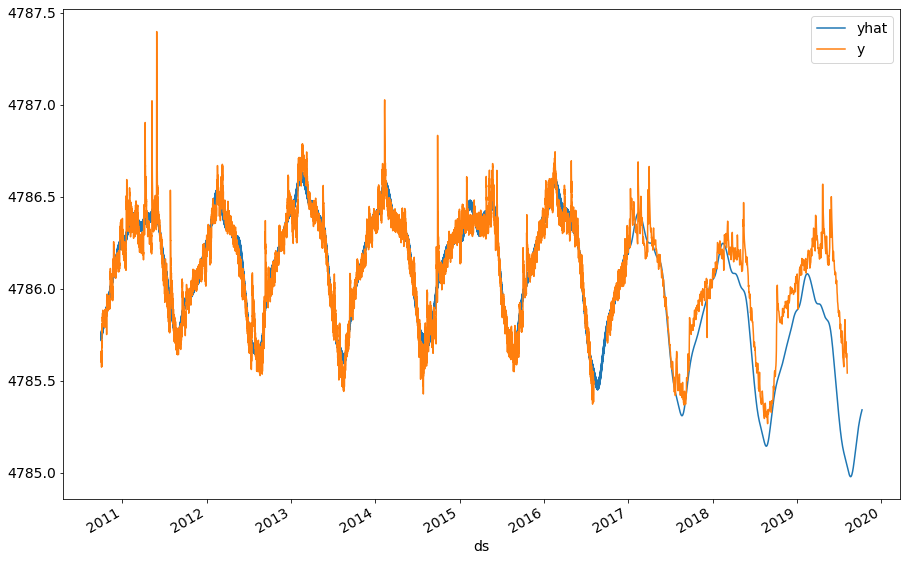

In [44]:
forecast_hr['SG25A_wle']['yhat'].plot()
forecast_hr['SG25A_wle']['y'].plot()
forecast_hr['SG25A_wle']['resid'] = forecast_hr['SG25A_wle']['y'] - forecast_hr['SG25A_wle']['yhat']
plt.legend()

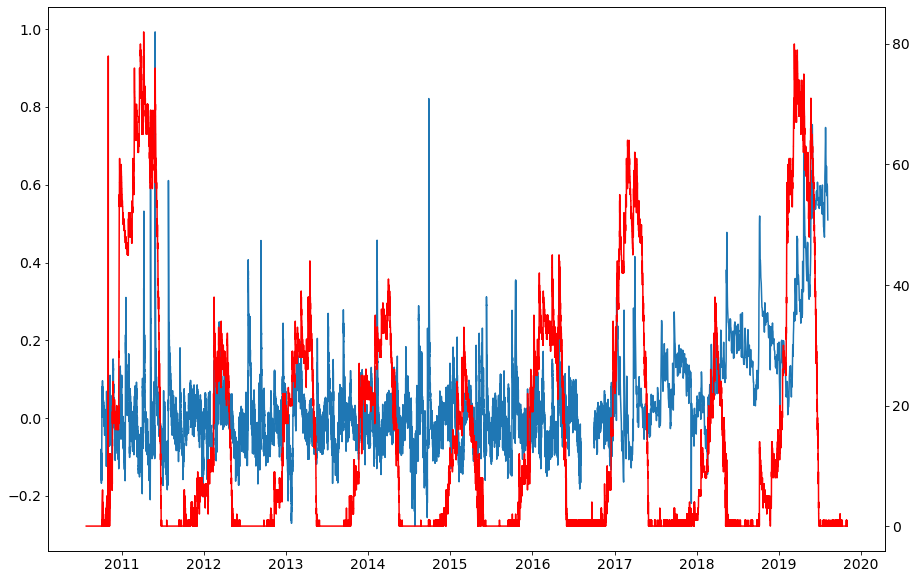

In [49]:
x = forecast_hr['SG25A_wle']['resid'].index
y = forecast_hr['SG25A_wle']['resid']
plt.plot(x,y)
plt.twinx()
x1 = sntlhrly['snd'].index
y1 = sntlhrly['snd']
plt.plot(x1,y1,color='red')

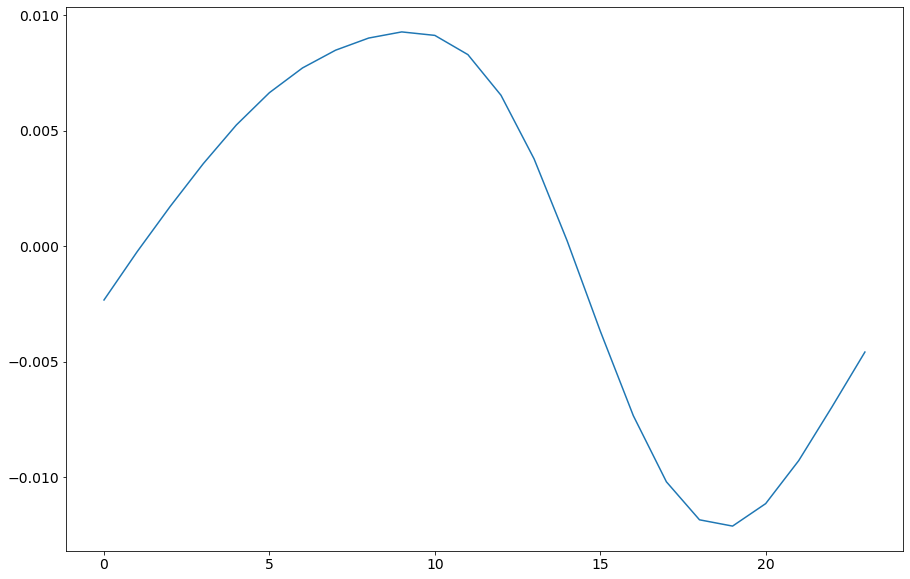

In [117]:
x = forecast_hr_reg['1011_wle'].daily.index.hour[:24]
y = forecast_hr_reg['1011_wle'].daily[:24]
plt.plot(x,y)

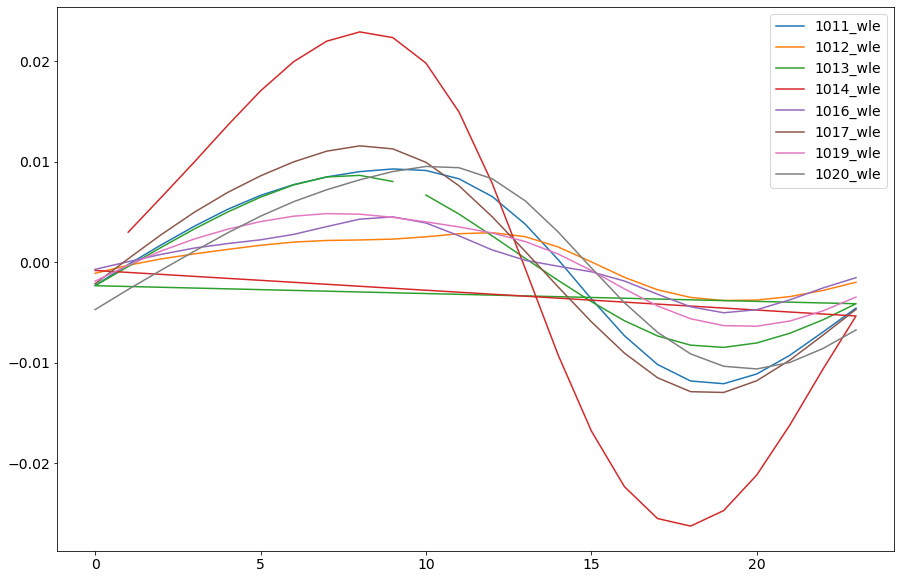

In [120]:

forecast_hr_reg = {}

for col in comb_data.columns:
    if 'wle' in col and col != '1061_wle' and 'SG' not in col:
        try:
            forecast_hr_reg[col] = pd.read_pickle(file_place+f'{col}_forecast_hourly_reg_v14.pickle')
            #forecast_dy[col] = pd.read_pickle(file_place+f'prophet_{col}_forecast_daily_v5.pickle')
            #forecast_hr_reg[col].trend.plot(label = col)
            #forecast_hr_reg[col].daily.plot()
            x = forecast_hr_reg[col].daily.index.hour[:24]
            y = forecast_hr_reg[col].daily[:24]
            plt.plot(x,y,label=col)
        except:
            pass
        
plt.legend()

In [104]:
forecast_hr_reg[col].daily.plot()

KeyError: 'swe'

In [92]:


for col in comb_data.columns:
    if 'wle' in col:
        forecast[col].trend.plot()

KeyError: 'SG25A_wle'